In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import diags, kron, eye
from scipy.sparse.linalg import spsolve
from scipy.sparse import lil_matrix, csr_matrix
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors


colors = {
    "midnight": "#21252d",
    "mathblue": "#1b91d6",
    "sky": "#8ecae6",
    "slatecard": "#1a1e2a",
    "lightblue": "#bfdbfe",
    "hoverblue": "#60a5fa",
    "slategray": "#1a1e2a",
    "softgray": "#9ca3af"
}


# Create a custom colormap using your colors
custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_cmap", [colors["midnight"], colors["mathblue"], colors["sky"], colors["lightblue"]]
)

# Poisson and Laplace Equation

## Steps to solve:
```python
class PoissonSolver2D:
    def __init__(self, f, domain, Nx, Ny, bc_dict):
        self.f = f
        self.domain = domain
        self.Nx, self.Ny = Nx, Ny
        self.bc = bc_dict

    def setup_grid(self):
        # setup x, y, h
        pass

    def apply_boundary_conditions(self):
        # handle Dirichlet, Neumann, etc.
        pass

    def assemble_matrix(self):
        # create sparse matrix A and RHS b
        pass

    def solve(self):
        # solve Au = b
```

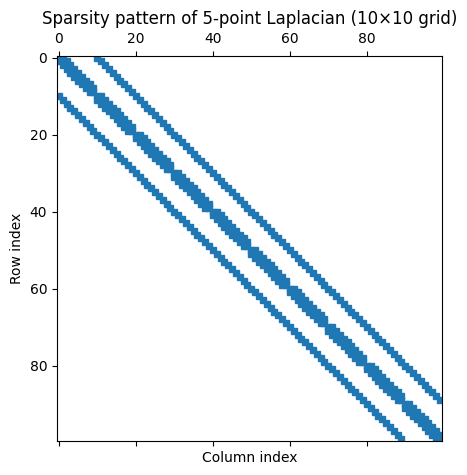

In [84]:
def build_laplacian(Nx, Ny):
    # returns CSR sparse matrix for the 5-point stencil
    data, rows, cols = [], [], []
    for j in range(Ny):
        for i in range(Nx):
            k = i + j*Nx          # flattened index
            rows += [k]; cols += [k]; data += [4.0]     # centre
            if i > 0:         rows += [k]; cols += [k-1];   data += [-1.0]
            if i < Nx-1:      rows += [k]; cols += [k+1];   data += [-1.0]
            if j > 0:         rows += [k]; cols += [k-Nx];  data += [-1.0]
            if j < Ny-1:      rows += [k]; cols += [k+Nx];  data += [-1.0]
    return sparse.csr_matrix((data, (rows, cols)), shape=(Nx*Ny, Nx*Ny))

Nx, Ny = 10, 10          # interior-grid dimensions – change as you like
A = build_laplacian(Nx, Ny)

plt.figure(figsize=(5,5))
plt.spy(A, markersize=5)
plt.title(f"Sparsity pattern of 5-point Laplacian ({Ny}×{Nx} grid)")
plt.xlabel("Column index"); plt.ylabel("Row index")
plt.show()


## Dirichlet (fixed value)


## Mixed / Robin Boundary

- combines Dirichlet and Neumann behaviour

$$
\alpha u +\beta \frac{\partial u}{\partial n} = \gamma
$$
- $\alpha = 1, \beta = 0 \implies $ pure Dirichlet
- $\alpha = 0, \beta = 1 \implies $ pure Neumann
- Typical heat-transfer form (Newton cooling): 
$$
\beta = k, \alpha = h_c, \gamma = h_c T_\infty
$$

---
1. First-order ghost-cell formula

On our uniform grid the outward normal derivative is approximated by:
$$
\frac{\partial u}{\partial n} \approx \frac{u_G - u_P}{h}
$$
so at a wall node $P$, the robin condition becomes:
$$
\alpha u_P +\beta \frac{u_G - u_P}{h} = \gamma
$$
solving for ghost value $u_G$ :
$$
u_G = u_P +\frac{h}{\beta}\left(\gamma -\alpha u_P\right)
$$
Set this each sweep so the ghost layer tracks the evolving interior.

---


## Neumann (flux) boundaries
the normal derivative 
$$
\frac{\partial u}{\partial n} \bigg\vert_{\text{wall}} = q(x,y),
$$
fixes the (heat)flux instead of temperature. On a uniform finite-difference grid the simplest (first-order) ghost-cell update is:
$$
u_G = u_P +qh
$$
where
- $u_P$ is the interior node adjacent to the wall
- $u_G$ is the ghost value just outside the wall,
- $h$ is grid spacing
- $q$ is derivative in the outward normal direction
    - positive $q$ means flux out of domain
Need to perform this update every sweep as $u_P$ keeps changing.


## Step 1: Problem Statement & Grid Discretization

Want to solve 2-d Poisson equation:
$$
-\nabla^2 u(x,y) = f(x,y), \quad (x,y) \in \Omega = [a,b] \times [c,d]
$$
with Dirchlet boundary conditions: 
$$
u(x,y) = g(x,y) \text{ on } \partial \Omega 
$$

## Discretize the domain $\Omega$ into a **uniform grid**

### 🧮 Mathematical Setup

We discretize the domain $\Omega$ into a **uniform grid**:

* $x_i = a + i h_x,\quad i = 0, 1, \dots, N_x$
* $y_j = c + j h_y,\quad j = 0, 1, \dots, N_y$
* Grid spacings: $h_x = \frac{b-a}{N_x},\quad h_y = \frac{d-c}{N_y}$

At each grid point $(x_i, y_j)$, we will approximate $u(x_i, y_j)$ by $u_{i,j}$

---

### 🧱 Discretization of $-\nabla^2 u$

Using second-order **central differences**, the Laplacian becomes:

$$
- \nabla^2 u(x_i, y_j) \approx -\left( \frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{h_x^2} + \frac{u_{i,j+1} - 2u_{i,j} + u_{i,j-1}}{h_y^2} \right)
$$

We’ll use this stencil to build a matrix equation.

---


In [85]:
class PoissonSolver2D:
    def __init__(self, a, b, c, d, Nx, Ny):
        self.a, self.b = a, b  # x-domain
        self.c, self.d = c, d  # y-domain
        self.Nx, self.Ny = Nx, Ny  # number of intervals

        # Step sizes
        self.hx = (b - a) / Nx
        self.hy = (d - c) / Ny

        # Grid points (including boundaries)
        self.x = np.linspace(a, b, Nx + 1)
        self.y = np.linspace(c, d, Ny + 1)

        # Meshgrid for convenience
        self.X, self.Y = np.meshgrid(self.x, self.y, indexing='ij')

        print(f"Grid setup complete: hx = {self.hx}, hy = {self.hy}")


In [86]:
solver = PoissonSolver2D(a=0, b=1, c=0, d=1, Nx=4, Ny=4)
print(solver.X)


Grid setup complete: hx = 0.25, hy = 0.25
[[0.   0.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25 0.25]
 [0.5  0.5  0.5  0.5  0.5 ]
 [0.75 0.75 0.75 0.75 0.75]
 [1.   1.   1.   1.   1.  ]]


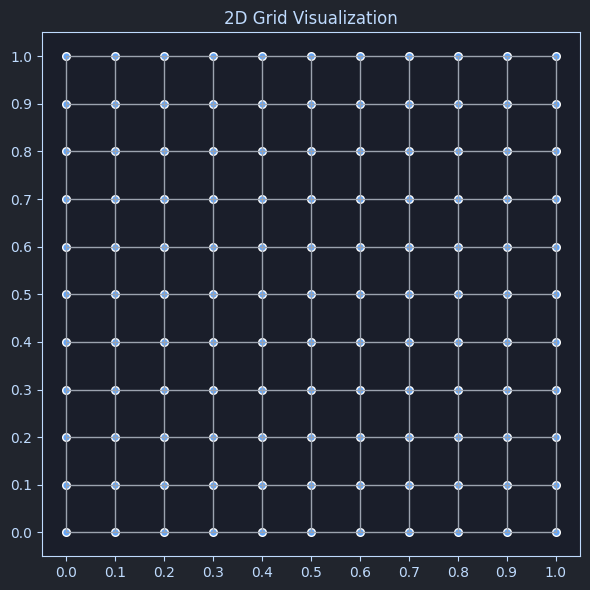

In [87]:
# Define the grid parameters
a, b, c, d = 0, 1, 0, 1
Nx, Ny = 10, 10
hx = (b - a) / Nx
hy = (d - c) / Ny

x = np.linspace(a, b, Nx + 1)
y = np.linspace(c, d, Ny + 1)
X, Y = np.meshgrid(x, y, indexing='ij')


# Plot the grid
fig, ax = plt.subplots(figsize=(6, 6))
fig.patch.set_facecolor(colors["midnight"])
ax.set_facecolor(colors["slatecard"])

# Plot horizontal lines
for j in range(Ny + 1):
    ax.plot([a, b], [y[j], y[j]], color=colors["softgray"], linewidth=1)

# Plot vertical lines
for i in range(Nx + 1):
    ax.plot([x[i], x[i]], [c, d], color=colors["softgray"], linewidth=1)

# Plot grid points
ax.scatter(X, Y, color=colors["hoverblue"], s=30, edgecolor='white')

# Aesthetic settings
ax.set_xlim(a - 0.05, b + 0.05)
ax.set_ylim(c - 0.05, d + 0.05)
ax.set_xticks(x)
ax.set_yticks(y)
ax.tick_params(colors=colors["lightblue"])
for spine in ax.spines.values():
    spine.set_edgecolor(colors["lightblue"])
ax.set_title("2D Grid Visualization", color=colors["lightblue"])

plt.grid(False)
plt.tight_layout()
plt.show()

##  Step 2: Setting Up the Right-Hand Side and Dirichlet BCs

We want to solve:

$$
- \nabla^2 u(x, y) = f(x, y), \quad \text{with } u(x, y) = g(x, y) \text{ on } \partial \Omega
$$

### 🎯 Objectives

1. Discretize $f(x, y)$ on the grid interior (i.e., not on boundaries).
2. Create an array `u` initialized with zeros.
3. Apply **Dirichlet** boundary conditions: explicitly set values of `u` on the domain boundary.

---

### 🧮 Mathematical View

Let $f_{i,j} = f(x_i, y_j)$ evaluated on the grid.
Dirichlet boundary conditions mean:

* For all points on the edge (i=0, i=Nx, j=0, j=Ny), set $u_{i,j} = g(x_i, y_j)$

This becomes:

* **Top** boundary → $j = Ny$
* **Bottom** boundary → $j = 0$
* **Left** boundary → $i = 0$
* **Right** boundary → $i = Nx$

We'll store this in a full 2D array `u[i, j]`.

---

### 🧑‍💻 Code: Setup `f(x, y)` and Apply Dirichlet BC


In [88]:
class PoissonSolver2D:
    def __init__(self, a, b, c, d, Nx, Ny, f_func, g_func):
        self.a, self.b, self.c, self.d = a, b, c, d
        self.Nx, self.Ny = Nx, Ny
        self.hx = (b - a) / Nx
        self.hy = (d - c) / Ny

        self.x = np.linspace(a, b, Nx + 1)
        self.y = np.linspace(c, d, Ny + 1)
        self.X, self.Y = np.meshgrid(self.x, self.y, indexing='ij')

        self.f_func = f_func
        self.g_func = g_func

        # Evaluate f on the grid
        self.f = f_func(self.X, self.Y)

        # Solution array
        self.u = np.zeros_like(self.f)

        # Apply Dirichlet boundary conditions
        self.apply_dirichlet_bc()

    def apply_dirichlet_bc(self):
        g = self.g_func

        # Left and Right boundaries
        self.u[0, :] = g(self.x[0], self.y)
        self.u[-1, :] = g(self.x[-1], self.y)

        # Bottom and Top boundaries
        self.u[:, 0] = g(self.x, self.y[0])
        self.u[:, -1] = g(self.x, self.y[-1])

---

### 🔍 Notes

* `f_func(x, y)` and `g_func(x, y)` are user-defined functions.
* `self.f` stores the discretized version of $f(x,y)$
* `self.u` stores the solution, with boundaries set according to $g(x,y)$

---

### ✅ Example Usage

Let’s use:

* $f(x,y) = 2\pi^2 \sin(\pi x)\sin(\pi y)$
* $g(x,y) = 0$ on boundary (homogeneous Dirichlet)

In [89]:
f = lambda x, y: 2 * np.pi**2 * np.sin(np.pi * x) * np.sin(np.pi * y)
g = lambda x, y: 0 * x  # all boundaries = 0

solver = PoissonSolver2D(0, 1, 0, 1, 10, 10, f_func=f, g_func=g)

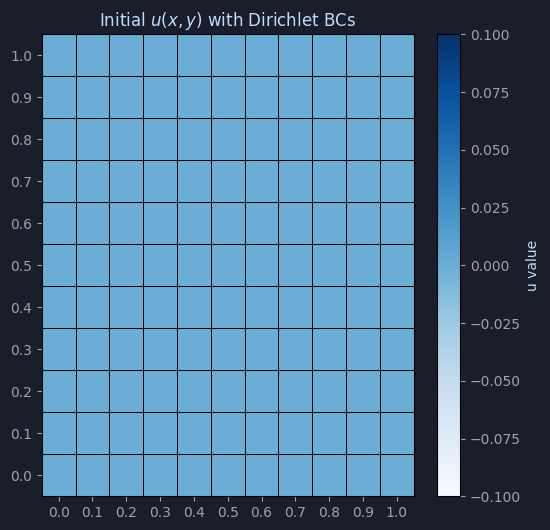

In [90]:

# Define domain and functions
a, b, c, d = 0, 1, 0, 1
Nx, Ny = 10, 10
hx = (b - a) / Nx
hy = (d - c) / Ny

x = np.linspace(a, b, Nx + 1)
y = np.linspace(c, d, Ny + 1)
X, Y = np.meshgrid(x, y, indexing='ij')

# Function f(x, y) = 2π² sin(πx) sin(πy)
f_func = lambda x, y: 2 * np.pi**2 * np.sin(np.pi * x) * np.sin(np.pi * y)
g_func = lambda x, y: 0 * x  # homogeneous Dirichlet

# Evaluate functions
f_vals = f_func(X, Y)
u_vals = np.zeros_like(f_vals)

# Apply Dirichlet BCs
u_vals[0, :] = g_func(x[0], y)
u_vals[-1, :] = g_func(x[-1], y)
u_vals[:, 0] = g_func(x, y[0])
u_vals[:, -1] = g_func(x, y[-1])


# Plot u values including boundary
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_facecolor(colors["midnight"])
fig.patch.set_facecolor(colors["slategray"])

c = ax.pcolormesh(X, Y, u_vals.T, shading='auto', cmap='Blues', edgecolors='k', linewidth=0.5)
ax.set_title("Initial $u(x, y)$ with Dirichlet BCs", color=colors["lightblue"])
ax.set_xticks(np.round(x, 2))
ax.set_yticks(np.round(y, 2))
ax.tick_params(colors=colors["softgray"])
cb = fig.colorbar(c, ax=ax)
cb.set_label("u value", color=colors["lightblue"])
cb.ax.tick_params(colors=colors["softgray"])  # Tick marks and labels

plt.show()


---

## 🔷 Step 3: Assembling the Sparse Matrix and Solving $A\mathbf{u} = \mathbf{f}$

We’ve set up the grid and applied Dirichlet boundary conditions. Now we will:

1. Discretize the Poisson equation at interior points.
2. Set up the sparse matrix $A$ corresponding to the 5-point stencil.
3. Flatten the system into vector form: $A \mathbf{u} = \mathbf{f}$
4. Solve it using a linear solver.

---

### 🎯 Mathematical Discretization

Recall:

$$
- \nabla^2 u(x_i, y_j) \approx -\left( \frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{h_x^2} + \frac{u_{i,j+1} - 2u_{i,j} + u_{i,j-1}}{h_y^2} \right)
$$

Define:

* $N = (N_x - 1)(N_y - 1)$: number of **interior** unknowns
* For interior points only: $1 \le i \le N_x - 1$, $1 \le j \le N_y - 1$

We flatten the 2D grid to 1D using **row-major order**:

$$
k = (i-1) \cdot (N_y - 1) + (j-1)
$$

---

### 🔧 Finite Difference Stencil in Matrix Form

Each interior point $u_{i,j}$ becomes one equation:

$$
A_{kk} = -2\left(\frac{1}{h_x^2} + \frac{1}{h_y^2}\right),\quad
A_{k,k\pm1} = \frac{1}{h_y^2},\quad
A_{k,k\pm(N_y-1)} = \frac{1}{h_x^2}
$$

This yields a **sparse matrix $A$**.

---

### 🧑‍💻 Code to Build A and Solve System


In [91]:
class PoissonSolver2D: #only square grid
    def __init__(self, a, b, c, d, Nx, Ny, f_func, g_func):
        self.a, self.b, self.c, self.d = a, b, c, d
        self.Nx, self.Ny = Nx, Ny
        self.hx = (b - a) / Nx
        self.hy = (d - c) / Ny
        self.x = np.linspace(a, b, Nx + 1)
        self.y = np.linspace(c, d, Ny + 1)
        self.X, self.Y = np.meshgrid(self.x, self.y, indexing='ij')

        self.f_func = f_func
        self.g_func = g_func
        self.f = f_func(self.X, self.Y)
        self.u = np.zeros_like(self.f)

        self.apply_dirichlet_bc()

    def apply_dirichlet_bc(self):
        g = self.g_func
        self.u[0, :] = g(self.x[0], self.y)
        self.u[-1, :] = g(self.x[-1], self.y)
        self.u[:, 0] = g(self.x, self.y[0])
        self.u[:, -1] = g(self.x, self.y[-1])

    def solve(self):
        Nx, Ny = self.Nx, self.Ny
        hx2 = self.hx ** 2
        hy2 = self.hy ** 2
        N = (Nx - 1) * (Ny - 1)

        A = lil_matrix((N, N))
        F = np.zeros(N)

        def idx(i, j):  # Convert (i,j) to 1D index
            return (i - 1) * (Ny - 1) + (j - 1)

        for i in range(1, Nx):
            for j in range(1, Ny):
                k = idx(i, j)
                A[k, k] = -2.0 * (1 / hx2 + 1 / hy2)

                # Neighbors
                if i > 1:
                    A[k, idx(i - 1, j)] = 1 / hx2
                else:
                    F[k] -= self.u[i - 1, j] / hx2  # Left boundary

                if i < Nx - 1:
                    A[k, idx(i + 1, j)] = 1 / hx2
                else:
                    F[k] -= self.u[i + 1, j] / hx2  # Right boundary

                if j > 1:
                    A[k, idx(i, j - 1)] = 1 / hy2
                else:
                    F[k] -= self.u[i, j - 1] / hy2  # Bottom boundary

                if j < Ny - 1:
                    A[k, idx(i, j + 1)] = 1 / hy2
                else:
                    F[k] -= self.u[i, j + 1] / hy2  # Top boundary

                F[k] += self.f[i, j]

        # Convert to CSR and solve
        A_csr = A.tocsr()
        u_inner = spsolve(A_csr, F)

        # Fill in the interior of u
        for i in range(1, Nx):
            for j in range(1, Ny):
                self.u[i, j] = u_inner[idx(i, j)]

        return self.u

In [92]:
f = lambda x, y: 2 * np.pi**2 * np.sin(np.pi * x) * np.sin(np.pi * y)
g = lambda x, y: 0 * x

solver = PoissonSolver2D(0, 1, 0, 1, 20, 20, f_func=f, g_func=g)
u_numeric = solver.solve()

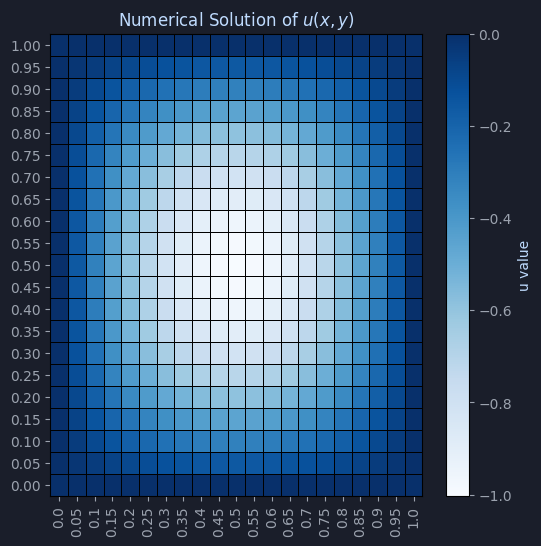

In [93]:
# Define domain and function
a, b, c, d = 0, 1, 0, 1
Nx, Ny = 20, 20
hx = (b - a) / Nx
hy = (d - c) / Ny

x = np.linspace(a, b, Nx + 1)
y = np.linspace(c, d, Ny + 1)
X, Y = np.meshgrid(x, y, indexing='ij')

# Functions
f_func = lambda x, y: 2 * np.pi**2 * np.sin(np.pi * x) * np.sin(np.pi * y)
g_func = lambda x, y: 0 * x

# Solve
solver = PoissonSolver2D(a, b, c, d, Nx, Ny, f_func, g_func)
u_numeric = solver.solve()

# Plot solution
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_facecolor(colors["midnight"])
fig.patch.set_facecolor(colors["slategray"])

c = ax.pcolormesh(solver.X, solver.Y, u_numeric.T, shading='auto', cmap='Blues', edgecolors='k', linewidth=0.5)
ax.set_title("Numerical Solution of $u(x, y)$", color=colors["lightblue"])
ax.set_xticks(np.round(x, 2))
ax.set_xticklabels(np.round(x, 2), rotation=90)  # <-- rotate x-tick labels
ax.set_yticks(np.round(y, 2))
ax.tick_params(colors=colors["softgray"])
cb = fig.colorbar(c, ax=ax)
cb.set_label("u value", color=colors["lightblue"])
cb.ax.tick_params(colors=colors["softgray"])

plt.show()


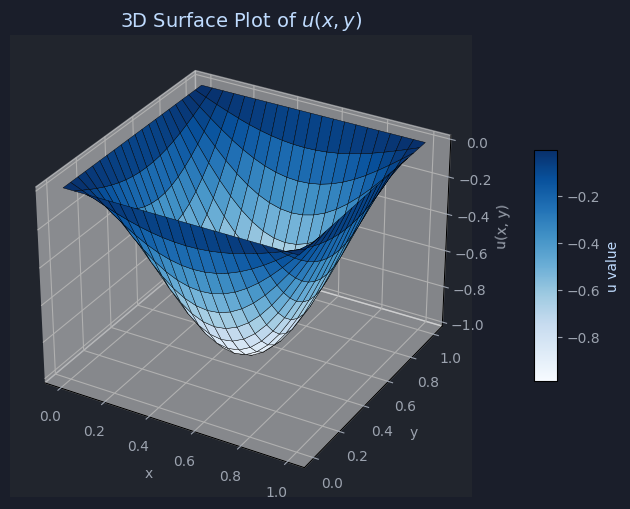

In [94]:

# 3D Surface Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
fig.patch.set_facecolor(colors["slategray"])
ax.set_facecolor(colors["midnight"])

# Plot surface
surf = ax.plot_surface(solver.X, solver.Y, u_numeric, cmap='Blues', edgecolor='k', linewidth=0.3, antialiased=True)

# Axis labels
ax.set_title("3D Surface Plot of $u(x, y)$", color=colors["lightblue"], fontsize=14)
ax.set_xlabel("x", color=colors["softgray"])
ax.set_ylabel("y", color=colors["softgray"])
ax.set_zlabel("u(x, y)", color=colors["softgray"])
ax.tick_params(colors=colors["softgray"])

# Color bar
cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)
cb.set_label("u value", color=colors["lightblue"])
cb.ax.tick_params(colors=colors["softgray"])

plt.show()

# Exercises
1. Approximate the solution to the elliptic partial differential equation
$$ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 4, \quad 0 < x < 1, \quad 0 < y < 2; $$
$$ u(x, 0) = x^2, \quad u(x, 2) = (x-2)^2, \quad 0 \leq x \leq 1; $$
$$ u(0, y) = y^2, \quad u(1, y) = (y-1)^2, \quad 0 \leq y \leq 2. $$
Use $h=k=\frac{1}{2}$ and compare the results to the actual solution $u(x, y) = (x-y)^2$.

2. Approximate the solution to the elliptic partial differential equation
$$ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0, \quad 1 < x < 2, \quad 0 < y < 1; $$
$$ u(x, 0) = 2 \ln x, \quad u(x, 1) = \ln(x^2 + 1), \quad 1 \leq x \leq 2; $$
$$ u(1, y) = \ln(y^2 + 1), \quad u(2, y) = \ln(y^2 + 4), \quad 0 \leq y \leq 1. $$
Use $h=k=\frac{1}{3}$ and compare the results to the actual solution $u(x, y) = \ln(x^2 + y^2)$.

## 3. Approximate the solutions to the following elliptic partial differential equations:

### a.

$$
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0, \quad 0 < x < 1,\quad 0 < y < 1;
$$

Boundary conditions:

- $u(x, 0) = 0$, $u(x, 1) = x$, $0 \leq x \leq 1$
- $u(0, y) = 0$, $u(1, y) = y$, $0 \leq y \leq 1$

Use $h = k = 0.2$ and compare the results to the actual solution:

$$
u(x, y) = xy
$$

---

### b.

$$
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = -(\cos(x + y) + \cos(x - y)), \quad 0 < x < \pi,\quad 0 < y < \frac{\pi}{2};
$$

Boundary conditions:

- $u(0, y) = \cos y$, $u(\pi, y) = -\cos y$, $0 \leq y \leq \frac{\pi}{2}$
- $u(x, 0) = \cos x$, $u\left(x, \frac{\pi}{2}\right) = 0$, $0 \leq x \leq \pi$

Use $h = \pi/5$ and $k = \pi/10$ and compare the results to the actual solution:

$$
u(x, y) = \cos x \cos y
$$

---

### c.

$$
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = (x^2 + y^2) e^{xy},\quad 0 < x < 2,\quad 0 < y < 1;
$$

Boundary conditions:

- $u(0, y) = 1$, $u(2, y) = e^{2y}$, $0 \leq y \leq 1$
- $u(x, 0) = 1$, $u(x, 1) = e^x$, $0 \leq x \leq 2$

Use $h = 0.2$ and $k = 0.1$ and compare the results to the actual solution:

$$
u(x, y) = e^{xy}
$$

---

### d.

$$
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = \frac{x}{y} + \frac{y}{x},\quad 1 < x < 2,\quad 1 < y < 2;
$$

Boundary conditions:

- $u(x, 1) = x \ln x$, $u(x, 2) = x \ln(4x^2)$, $1 \leq x \leq 2$
- $u(1, y) = y \ln y$, $u(2, y) = 2y \ln(2y)$, $1 \leq y \leq 2$

Use $h = k = 0.1$ and compare the results to the actual solution:

$$
u(x, y) = xy \ln(xy)
$$

---

## 4.

Repeat Exercise 3(a) using extrapolation with $h_0 = 0.2$, $h_1 = h_0 / 2$, and $h_2 = h_0 / 4$.

## Applied Exercises

### 5.

A coaxial cable is made of a 0.1-in.-square inner conductor and a 0.5-in.-square outer conductor.  
The potential at a point in the cross section of the cable is described by Laplace’s equation.  
Suppose the inner conductor is kept at 0 volts and the outer conductor is kept at 110 volts.  
Find the potential between the two conductors by placing a grid with horizontal mesh spacing  
$h = 0.1$ in. and vertical mesh spacing $k = 0.1$ in. on the region

$$
D = \{(x, y) \mid 0 \leq x, y \leq 0.5 \}.
$$

Approximate the solution to Laplace’s equation at each grid point and use the two sets of boundary conditions to derive a linear system to be solved by the Gauss-Seidel method.

---

### 6.

A 6-cm by 5-cm rectangular silver plate has heat being uniformly generated at each point at the rate  
$q = 1.5$ cal/cm³·sec. Let $x$ represent the distance along the edge of the plate of length 6 cm and $y$ be the distance along the edge of the plate of length 5 cm.  
Suppose the temperature $u$ along the edges is kept at the following temperatures:

- $u(x, 0) = x(6 - x)$, $u(x, 5) = 0$, $0 \leq x \leq 6$
- $u(0, y) = y(5 - y)$, $u(6, y) = 0$, $0 \leq y \leq 5$

The Poisson equation governing the steady-state temperature $u = u(x, y)$ is:

$$
\frac{\partial^2 u}{\partial x^2}(x, y) + \frac{\partial^2 u}{\partial y^2}(x, y) = -\frac{q}{K}, \quad 0 < x < 6,\quad 0 < y < 5,
$$

where $K$, the thermal conductivity, is $1.04$ cal/cm·deg·sec.  
Approximate the temperature $u(x, y)$ using Algorithm 12.1 with $h = 0.4$ and $k = \frac{1}{3}$.

## Theoretical Exercises

### 7. 
Construct an algorithm similar to Algorithm 12.1, except use the SOR method with optimal $\omega$ instead of the Gauss-Seidel method for solving the linear system.

### 8. 
Repeat Exercise 3 using the algorithm constructed in Exercise 7.

## Discussion Questions

### 9. 
 The text describes the formation of equally spaced vertical grid lines and equally spaced horizontal grid lines. Can a variable grid size be used in the finite-difference method? If so, how could you implement this modification?
### 10.
 How would you space the grid lines in the case of an irregularly shaped domain?
### 11.
 Discuss multigrid methods for solving elliptical problems.


## Problem 1

In [95]:
class PoissonSolver2D:
    def __init__(self, a, b, c, d, Nx, Ny, f_func,
                 g_left, g_right, g_bottom, g_top):
        self.a, self.b, self.c, self.d = a, b, c, d
        self.Nx, self.Ny = Nx, Ny
        self.hx = (b - a) / Nx
        self.hy = (d - c) / Ny
        self.x = np.linspace(a, b, Nx + 1)
        self.y = np.linspace(c, d, Ny + 1)
        self.X, self.Y = np.meshgrid(self.x, self.y, indexing='ij')

        self.f_func = f_func
        self.f = f_func(self.X, self.Y)

        self.g_left = g_left
        self.g_right = g_right
        self.g_bottom = g_bottom
        self.g_top = g_top

        self.u = np.zeros_like(self.f)

        self.apply_dirichlet_bc()

    def apply_dirichlet_bc(self):
        # Apply to edges
        self.u[0, :] = self.g_left(self.y)
        self.u[-1, :] = self.g_right(self.y)
        self.u[:, 0] = self.g_bottom(self.x)
        self.u[:, -1] = self.g_top(self.x)

    def solve(self):
        from scipy.sparse import lil_matrix
        from scipy.sparse.linalg import spsolve

        Nx, Ny = self.Nx, self.Ny
        hx2 = self.hx ** 2
        hy2 = self.hy ** 2
        N = (Nx - 1) * (Ny - 1)

        A = lil_matrix((N, N))
        F = np.zeros(N)

        def idx(i, j):
            return (i - 1) * (Ny - 1) + (j - 1)

        for i in range(1, Nx):
            for j in range(1, Ny):
                k = idx(i, j)
                A[k, k] = -2.0 * (1 / hx2 + 1 / hy2)

                if i > 1:
                    A[k, idx(i - 1, j)] = 1 / hx2
                else:
                    F[k] -= self.u[i - 1, j] / hx2

                if i < Nx - 1:
                    A[k, idx(i + 1, j)] = 1 / hx2
                else:
                    F[k] -= self.u[i + 1, j] / hx2

                if j > 1:
                    A[k, idx(i, j - 1)] = 1 / hy2
                else:
                    F[k] -= self.u[i, j - 1] / hy2

                if j < Ny - 1:
                    A[k, idx(i, j + 1)] = 1 / hy2
                else:
                    F[k] -= self.u[i, j + 1] / hy2

                F[k] += self.f[i, j]

        u_inner = spsolve(A.tocsr(), F)

        for i in range(1, Nx):
            for j in range(1, Ny):
                self.u[i, j] = u_inner[idx(i, j)]

        return self.u


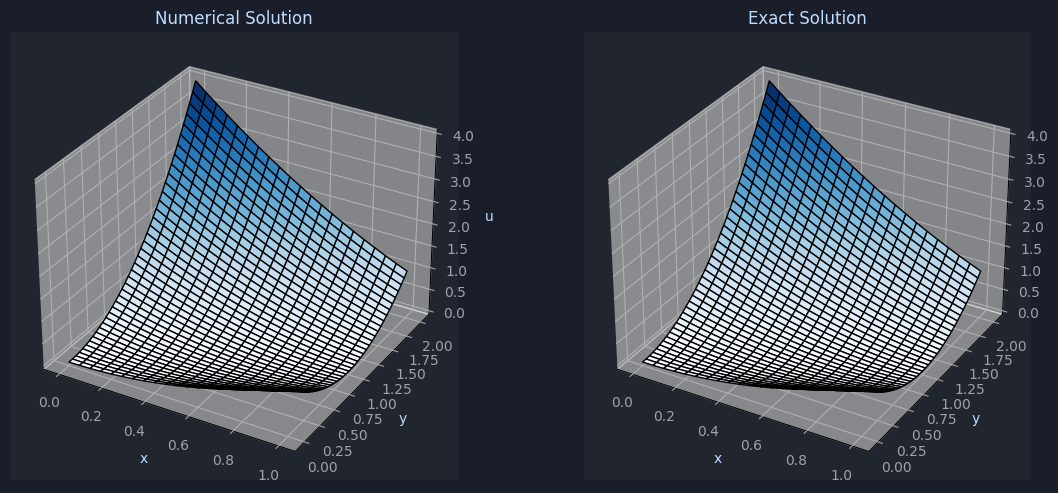

In [96]:
# Define problem-specific functions for test case
a, b = 0, 1
c, d = 0, 2
Nx, Ny = 20, 40 # h = k = 0.5 -> (Nx+1)x(Ny+1) = 3 x 5 grid

# RHS of Poisson equation
f_func = lambda x, y: 4 * np.ones_like(x)

# Dirichlet boundary conditions
g_bottom = lambda x: x**2
g_top = lambda x: (x - 2)**2
g_left = lambda y: y**2
g_right = lambda y: (y - 1)**2

# Exact solution
u_exact = lambda x, y: (x - y)**2

# Create and solve
solver = PoissonSolver2D(a, b, c, d, Nx, Ny, f_func,
                         g_left=g_left, g_right=g_right,
                         g_bottom=g_bottom, g_top=g_top)
u_numeric = solver.solve()

# Evaluate exact solution
X, Y = solver.X, solver.Y
u_true = u_exact(X, Y)
error = np.abs(u_numeric - u_true)

# Plot numerical solution vs exact solution
fig, axs = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={"projection": "3d"})
fig.patch.set_facecolor(colors["slategray"])

# Apply theme to each subplot
for ax in axs:
    ax.set_facecolor(colors["midnight"])
    ax.xaxis.label.set_color(colors["lightblue"])
    ax.yaxis.label.set_color(colors["lightblue"])
    ax.zaxis.label.set_color(colors["lightblue"])
    ax.tick_params(colors=colors["softgray"])
    ax.title.set_color(colors["lightblue"])

# Numerical solution
surf1 = axs[0].plot_surface(X, Y, u_numeric, cmap='Blues', edgecolor='k')
axs[0].set_title("Numerical Solution")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].set_zlabel("u")

# Exact solution
surf2 = axs[1].plot_surface(X, Y, u_true, cmap='Blues', edgecolor='k')
axs[1].set_title("Exact Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].set_zlabel("u")



plt.tight_layout()
plt.show()

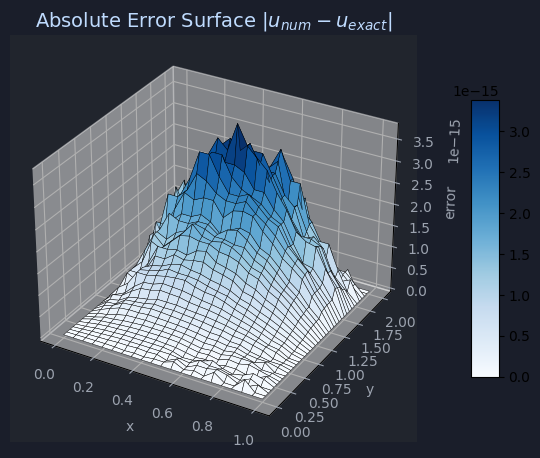

In [97]:
# Compute error surface
error = np.abs(u_numeric - u_true)

# Plot error surface using your custom theme
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
fig.patch.set_facecolor(colors["slategray"])
ax.set_facecolor(colors["midnight"])

# Plot error surface
surf = ax.plot_surface(X, Y, error, cmap='Blues', edgecolor='k', linewidth=0.3)

# Axis labels and title
ax.set_title("Absolute Error Surface $|u_{num} - u_{exact}|$", color=colors["lightblue"], fontsize=14)
ax.set_xlabel("x", color=colors["softgray"])
ax.set_ylabel("y", color=colors["softgray"])
ax.set_zlabel("error", color=colors["softgray"])
ax.tick_params(colors=colors["softgray"])

# Colorbar
fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, pad=0.1)

plt.show()


## Problem 2

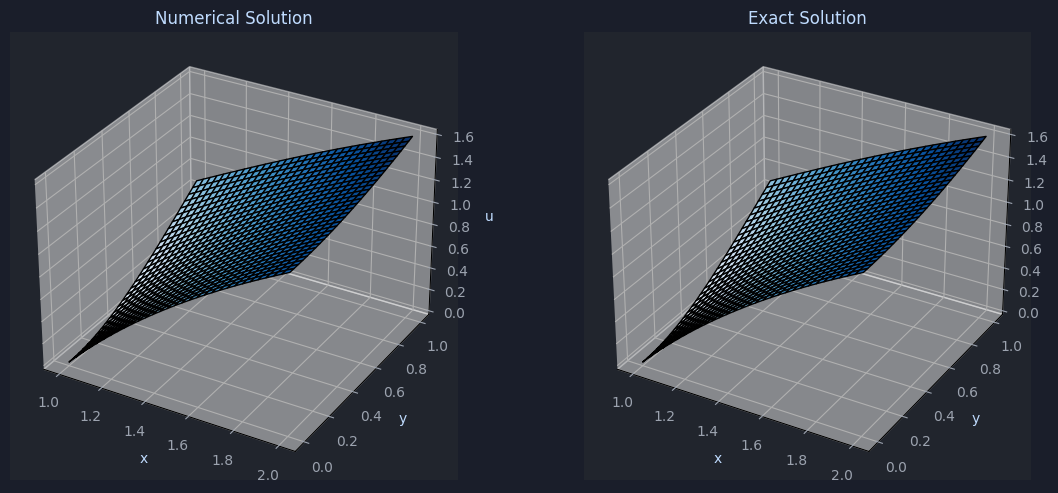

In [98]:
# Define domain and resolution
a, b = 1, 2
c, d = 0, 1
Nx, Ny = 30, 30  # h = k = 1/3 -> (Nx+1)x(Ny+1) = 4 x 4 grid

# Define f(x, y) = 0 (Laplace's equation)
f_func = lambda x, y: np.zeros_like(x)

# Define boundary conditions
g_bottom = lambda x: 2 * np.log(x)             # u(x, 0)
g_top = lambda x: np.log(x**2 + 1)             # u(x, 1)
g_left = lambda y: np.log(y**2 + 1)            # u(1, y)
g_right = lambda y: np.log(y**2 + 4)           # u(2, y)

# Define exact solution
u_exact = lambda x, y: np.log(x**2 + y**2)

# Solve using the updated class
solver = PoissonSolver2D(a, b, c, d, Nx, Ny, f_func,
                         g_left=g_left, g_right=g_right,
                         g_bottom=g_bottom, g_top=g_top)
u_numeric = solver.solve()

# Evaluate exact solution
X, Y = solver.X, solver.Y
u_true = u_exact(X, Y)
error = np.abs(u_numeric - u_true)

# Plot numerical solution vs exact solution
fig, axs = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={"projection": "3d"})
fig.patch.set_facecolor(colors["slategray"])

# Apply theme to each subplot
for ax in axs:
    ax.set_facecolor(colors["midnight"])
    ax.xaxis.label.set_color(colors["lightblue"])
    ax.yaxis.label.set_color(colors["lightblue"])
    ax.zaxis.label.set_color(colors["lightblue"])
    ax.tick_params(colors=colors["softgray"])
    ax.title.set_color(colors["lightblue"])

# Numerical solution
surf1 = axs[0].plot_surface(X, Y, u_numeric, cmap='Blues', edgecolor='k')
axs[0].set_title("Numerical Solution")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].set_zlabel("u")

# Exact solution
surf2 = axs[1].plot_surface(X, Y, u_true, cmap='Blues', edgecolor='k')
axs[1].set_title("Exact Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].set_zlabel("u")



plt.tight_layout()
plt.show()


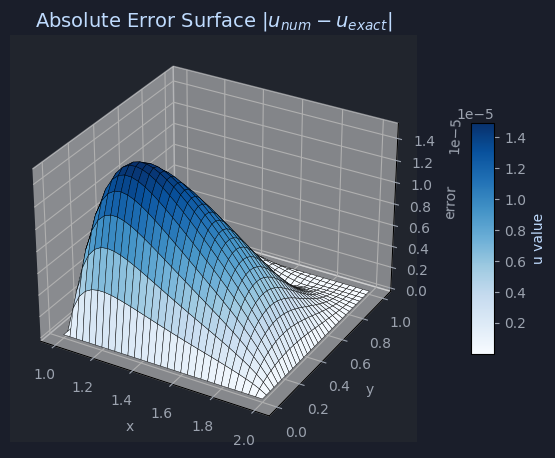

In [99]:
# Compute error surface
error = np.abs(u_numeric - u_true)

# Plot error surface using your custom theme
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
fig.patch.set_facecolor(colors["slategray"])
ax.set_facecolor(colors["midnight"])

# Plot error surface
surf = ax.plot_surface(X, Y, error, cmap='Blues', edgecolor='k', linewidth=0.3)

# Axis labels and title
ax.set_title("Absolute Error Surface $|u_{num} - u_{exact}|$", color=colors["lightblue"], fontsize=14)
ax.set_xlabel("x", color=colors["softgray"])
ax.set_ylabel("y", color=colors["softgray"])
ax.set_zlabel("error", color=colors["softgray"])
ax.tick_params(colors=colors["softgray"])

# Colorbar

# Color bar
cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)
cb.set_label("u value", color=colors["lightblue"])
cb.ax.tick_params(colors=colors["softgray"])
plt.show()


## Problem 3
### a) Approximate the solutions to the following elliptic partial differential equations:


$$
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0, \quad 0 < x < 1,\quad 0 < y < 1;
$$

Boundary conditions:

- $u(x, 0) = 0$, $u(x, 1) = x$, $0 \leq x \leq 1$
- $u(0, y) = 0$, $u(1, y) = y$, $0 \leq y \leq 1$

Use $h = k = 0.2$ and compare the results to the actual solution:

$$
u(x, y) = xy
$$


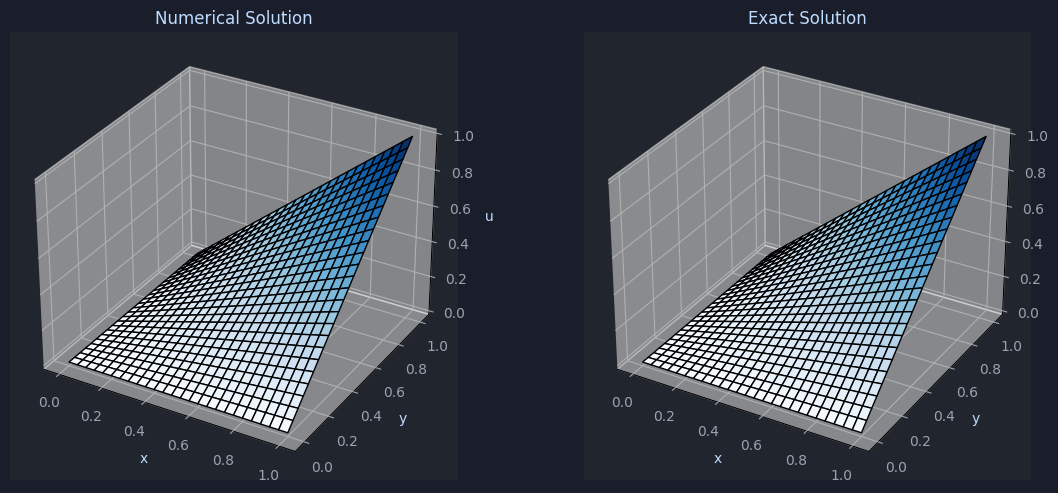

In [100]:
# Define domain and resolution
a, b = 0, 1
c, d = 0, 1
Nx, Ny = 50, 50  # h = k = 0.2 -> (Nx+1)x(Ny+1) = 6 x 6 grid

# RHS of Laplace equation
f_func = lambda x, y: np.zeros_like(x)

# Dirichlet boundary conditions
g_bottom = lambda x: 0 * x       # u(x, 0) = 0
g_top = lambda x: x              # u(x, 1) = x
g_left = lambda y: 0 * y         # u(0, y) = 0
g_right = lambda y: y            # u(1, y) = y

# Exact solution
u_exact = lambda x, y: x * y

# Solve using the PoissonSolver2D class
solver = PoissonSolver2D(a, b, c, d, Nx, Ny, f_func,
                         g_left=g_left, g_right=g_right,
                         g_bottom=g_bottom, g_top=g_top)
u_numeric = solver.solve()
# Evaluate exact solution
X, Y = solver.X, solver.Y
u_true = u_exact(X, Y)
error = np.abs(u_numeric - u_true)

# Plot numerical solution vs exact solution
fig, axs = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={"projection": "3d"})
fig.patch.set_facecolor(colors["slategray"])

# Apply theme to each subplot
for ax in axs:
    ax.set_facecolor(colors["midnight"])
    ax.xaxis.label.set_color(colors["lightblue"])
    ax.yaxis.label.set_color(colors["lightblue"])
    ax.zaxis.label.set_color(colors["lightblue"])
    ax.tick_params(colors=colors["softgray"])
    ax.title.set_color(colors["lightblue"])

# Numerical solution
surf1 = axs[0].plot_surface(X, Y, u_numeric, cmap='Blues', edgecolor='k')
axs[0].set_title("Numerical Solution")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].set_zlabel("u")

# Exact solution
surf2 = axs[1].plot_surface(X, Y, u_true, cmap='Blues', edgecolor='k')
axs[1].set_title("Exact Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].set_zlabel("u")



plt.tight_layout()
plt.show()



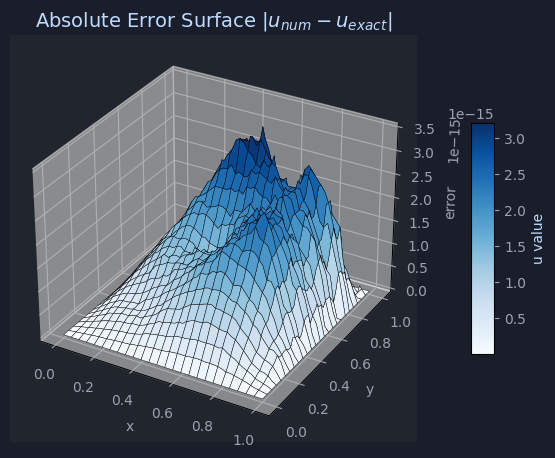

In [101]:
# Compute error surface
error = np.abs(u_numeric - u_true)

# Plot error surface using your custom theme
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
fig.patch.set_facecolor(colors["slategray"])
ax.set_facecolor(colors["midnight"])

# Plot error surface
surf = ax.plot_surface(X, Y, error, cmap='Blues', edgecolor='k', linewidth=0.3)

# Axis labels and title
ax.set_title("Absolute Error Surface $|u_{num} - u_{exact}|$", color=colors["lightblue"], fontsize=14)
ax.set_xlabel("x", color=colors["softgray"])
ax.set_ylabel("y", color=colors["softgray"])
ax.set_zlabel("error", color=colors["softgray"])
ax.tick_params(colors=colors["softgray"])

# Colorbar

# Color bar
cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)
cb.set_label("u value", color=colors["lightblue"])
cb.ax.tick_params(colors=colors["softgray"])
plt.show()


### b.

$$
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = -(\cos(x + y) + \cos(x - y)), \quad 0 < x < \pi,\quad 0 < y < \frac{\pi}{2};
$$

Boundary conditions:

- $u(0, y) = \cos y$, $u(\pi, y) = -\cos y$, $0 \leq y \leq \frac{\pi}{2}$
- $u(x, 0) = \cos x$, $u\left(x, \frac{\pi}{2}\right) = 0$, $0 \leq x \leq \pi$

Use $h = \pi/5$ and $k = \pi/10$ and compare the results to the actual solution:

$$
u(x, y) = \cos x \cos y
$$

---

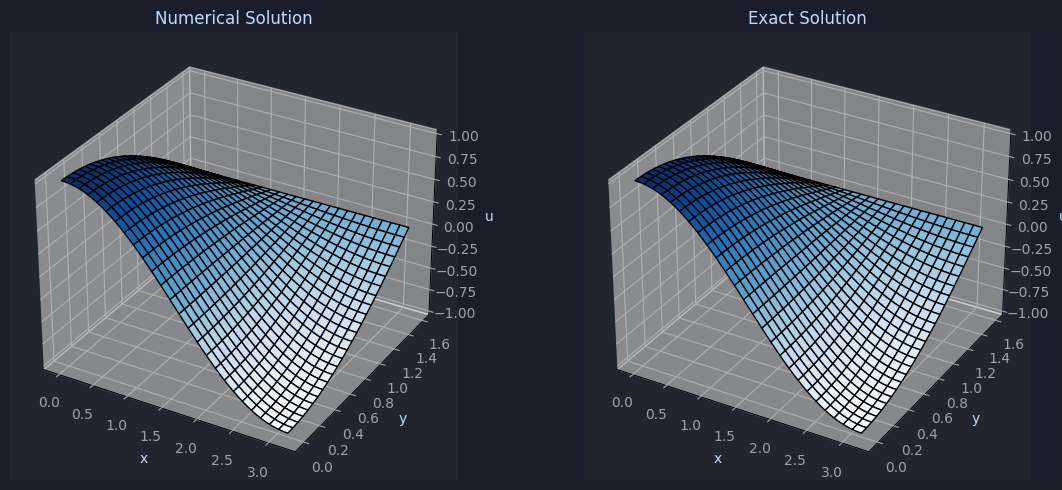

In [102]:
# Define domain and resolution
a, b = 0, np.pi
c, d = 0, np.pi/2
Nx, Ny = 50, 50  # h = k = 0.2 -> (Nx+1)x(Ny+1) = 6 x 6 grid

# RHS of Laplace equation
f_func = lambda x, y: -(np.cos(x+y)+np.cos(x-y))

# Dirichlet boundary conditions
g_bottom = lambda x: np.cos(x)
g_top = lambda x: 0*x
g_left = lambda y: np.cos(y)         # u(0, y) = 0
g_right = lambda y: -np.cos(y)            # u(1, y) = y

# Exact solution
u_exact = lambda x, y: np.cos(x) * np.cos(y)

# Solve using the PoissonSolver2D class
solver = PoissonSolver2D(a, b, c, d, Nx, Ny, f_func,
                         g_left=g_left, g_right=g_right,
                         g_bottom=g_bottom, g_top=g_top)
u_numeric = solver.solve()
# Evaluate exact solution
X, Y = solver.X, solver.Y
u_true = u_exact(X, Y)
error = np.abs(u_numeric - u_true)

# Plot numerical solution vs exact solution
fig, axs = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={"projection": "3d"})
fig.patch.set_facecolor(colors["slategray"])

# Apply theme to each subplot
for ax in axs:
    ax.set_facecolor(colors["midnight"])
    ax.xaxis.label.set_color(colors["lightblue"])
    ax.yaxis.label.set_color(colors["lightblue"])
    ax.zaxis.label.set_color(colors["lightblue"])
    ax.tick_params(colors=colors["softgray"])
    ax.title.set_color(colors["lightblue"])

# Numerical solution
surf1 = axs[0].plot_surface(X, Y, u_numeric, cmap='Blues', edgecolor='k')
axs[0].set_title("Numerical Solution")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].set_zlabel("u")

# Exact solution
surf2 = axs[1].plot_surface(X, Y, u_true, cmap='Blues', edgecolor='k')
axs[1].set_title("Exact Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].set_zlabel("u")



plt.tight_layout()
plt.show()



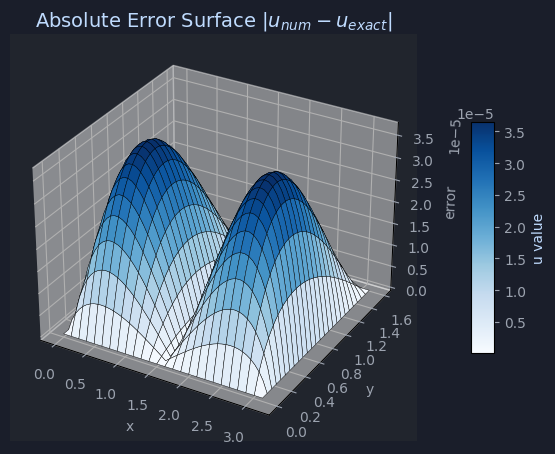

In [103]:
# Compute error surface
error = np.abs(u_numeric - u_true)

# Plot error surface using your custom theme
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
fig.patch.set_facecolor(colors["slategray"])
ax.set_facecolor(colors["midnight"])

# Plot error surface
surf = ax.plot_surface(X, Y, error, cmap='Blues', edgecolor='k', linewidth=0.3)

# Axis labels and title
ax.set_title("Absolute Error Surface $|u_{num} - u_{exact}|$", color=colors["lightblue"], fontsize=14)
ax.set_xlabel("x", color=colors["softgray"])
ax.set_ylabel("y", color=colors["softgray"])
ax.set_zlabel("error", color=colors["softgray"])
ax.tick_params(colors=colors["softgray"])

# Colorbar

# Color bar
cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)
cb.set_label("u value", color=colors["lightblue"])
cb.ax.tick_params(colors=colors["softgray"])
plt.show()


### c.

$$
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = (x^2 + y^2) e^{xy},\quad 0 < x < 2,\quad 0 < y < 1;
$$

Boundary conditions:

- $u(0, y) = 1$, $u(2, y) = e^{2y}$, $0 \leq y \leq 1$
- $u(x, 0) = 1$, $u(x, 1) = e^x$, $0 \leq x \leq 2$

Use $h = 0.2$ and $k = 0.1$ and compare the results to the actual solution:

$$
u(x, y) = e^{xy}
$$

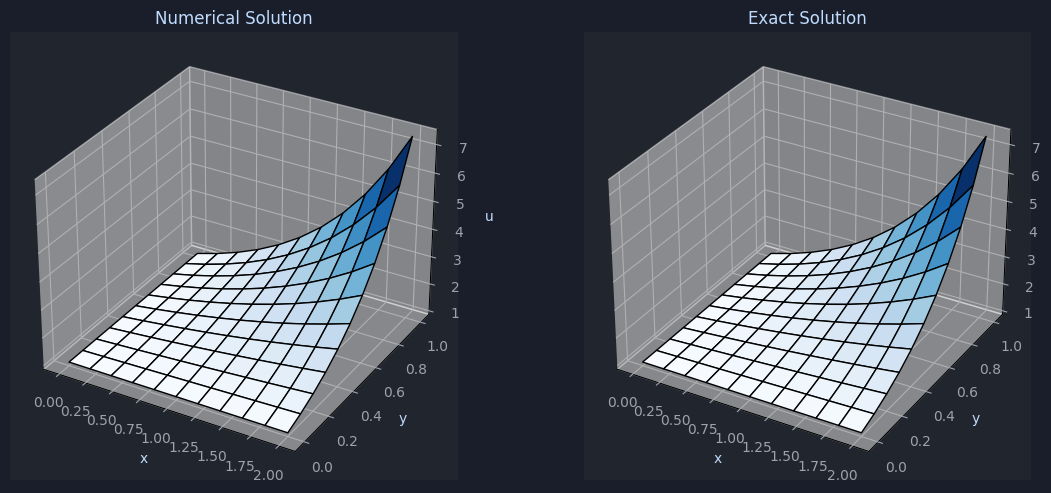

In [104]:
# Define domain and resolution
a, b = 0, 2
c, d = 0, 1
hx, hy = 0.2, 0.1
Nx, Ny = int((b - a) / hx), int((d - c) / hy)

# RHS of Laplace equation
f_func = lambda x, y: (x**2 + y**2) * np.exp(x * y)

# Boundary conditions
g_left = lambda y: np.ones_like(y)           # u(0, y) = 1
g_right = lambda y: np.exp(2 * y)            # u(2, y) = e^{2y}
g_bottom = lambda x: np.ones_like(x)         # u(x, 0) = 1
g_top = lambda x: np.exp(x)                  # u(x, 1) = e^x

# Exact solution
u_exact = lambda x, y: np.exp(x * y)

# Solve using the PoissonSolver2D class
solver = PoissonSolver2D(a, b, c, d, Nx, Ny, f_func,
                         g_left=g_left, g_right=g_right,
                         g_bottom=g_bottom, g_top=g_top)
u_numeric = solver.solve()
# Evaluate exact solution
X, Y = solver.X, solver.Y
u_true = u_exact(X, Y)
error = np.abs(u_numeric - u_true)

# Plot numerical solution vs exact solution
fig, axs = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={"projection": "3d"})
fig.patch.set_facecolor(colors["slategray"])

# Apply theme to each subplot
for ax in axs:
    ax.set_facecolor(colors["midnight"])
    ax.xaxis.label.set_color(colors["lightblue"])
    ax.yaxis.label.set_color(colors["lightblue"])
    ax.zaxis.label.set_color(colors["lightblue"])
    ax.tick_params(colors=colors["softgray"])
    ax.title.set_color(colors["lightblue"])

# Numerical solution
surf1 = axs[0].plot_surface(X, Y, u_numeric, cmap='Blues', edgecolor='k')
axs[0].set_title("Numerical Solution")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].set_zlabel("u")

# Exact solution
surf2 = axs[1].plot_surface(X, Y, u_true, cmap='Blues', edgecolor='k')
axs[1].set_title("Exact Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].set_zlabel("u")



plt.tight_layout()
plt.show()



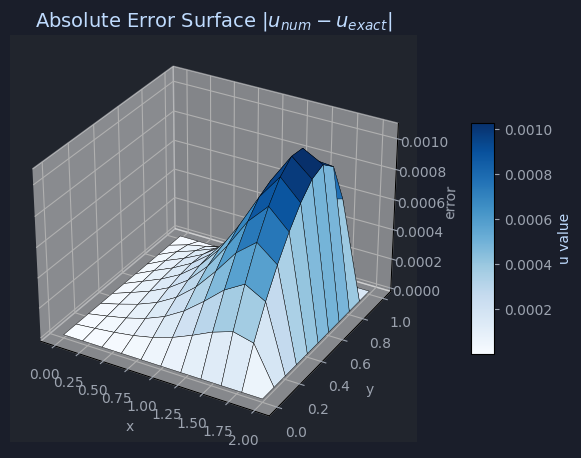

In [105]:
# Compute error surface
error = np.abs(u_numeric - u_true)

# Plot error surface using your custom theme
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
fig.patch.set_facecolor(colors["slategray"])
ax.set_facecolor(colors["midnight"])

# Plot error surface
surf = ax.plot_surface(X, Y, error, cmap='Blues', edgecolor='k', linewidth=0.3)

# Axis labels and title
ax.set_title("Absolute Error Surface $|u_{num} - u_{exact}|$", color=colors["lightblue"], fontsize=14)
ax.set_xlabel("x", color=colors["softgray"])
ax.set_ylabel("y", color=colors["softgray"])
ax.set_zlabel("error", color=colors["softgray"])
ax.tick_params(colors=colors["softgray"])

# Colorbar

# Color bar
cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)
cb.set_label("u value", color=colors["lightblue"])
cb.ax.tick_params(colors=colors["softgray"])
plt.show()


### d.
$$
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = \frac{x}{y} + \frac{y}{x},\quad 1 < x < 2,\quad 1 < y < 2;
$$

Boundary conditions:

- $u(x, 1) = x \ln x$, $u(x, 2) = x \ln(4x^2)$, $1 \leq x \leq 2$
- $u(1, y) = y \ln y$, $u(2, y) = 2y \ln(2y)$, $1 \leq y \leq 2$

Use $h = k = 0.1$ and compare the results to the actual solution:

$$
u(x, y) = xy \ln(xy)
$$

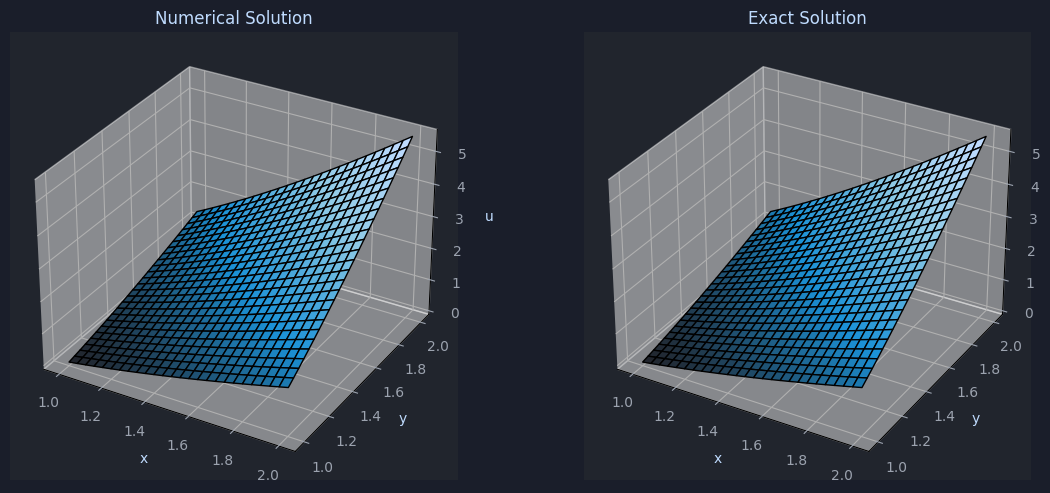

In [106]:
# Define domain and resolution
a, b = 1,2
c, d = 1,2
Nx, Ny = 50, 50  # h = k = 0.2 -> (Nx+1)x(Ny+1) = 6 x 6 grid

# RHS of Laplace equation
f_func = lambda x, y: x/y +y/x

# Dirichlet boundary conditions
g_top = lambda x: x*np.log(4*x**2)
g_bottom = lambda x: x*np.log(x)
g_left = lambda y: y*np.log(y)         # u(0, y) = 0
g_right = lambda y: 2*y*np.log(2*y)            # u(1, y) = y

# Exact solution
u_exact = lambda x, y: x * y * np.log(x * y)

# Solve using the PoissonSolver2D class
solver = PoissonSolver2D(a, b, c, d, Nx, Ny, f_func,
                         g_left=g_left, g_right=g_right,
                         g_bottom=g_bottom, g_top=g_top)
u_numeric = solver.solve()
# Evaluate exact solution
X, Y = solver.X, solver.Y
u_true = u_exact(X, Y)
error = np.abs(u_numeric - u_true)

# Plot numerical solution vs exact solution
fig, axs = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={"projection": "3d"})
fig.patch.set_facecolor(colors["slategray"])

# Apply theme to each subplot
for ax in axs:
    ax.set_facecolor(colors["midnight"])
    ax.xaxis.label.set_color(colors["lightblue"])
    ax.yaxis.label.set_color(colors["lightblue"])
    ax.zaxis.label.set_color(colors["lightblue"])
    ax.tick_params(colors=colors["softgray"])
    ax.title.set_color(colors["lightblue"])

# Numerical solution
surf1 = axs[0].plot_surface(X, Y, u_numeric, cmap=custom_cmap, edgecolor='k')
axs[0].set_title("Numerical Solution")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].set_zlabel("u")

# Exact solution
surf2 = axs[1].plot_surface(X, Y, u_true, cmap=custom_cmap, edgecolor='k')
axs[1].set_title("Exact Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].set_zlabel("u")



plt.tight_layout()
plt.show()



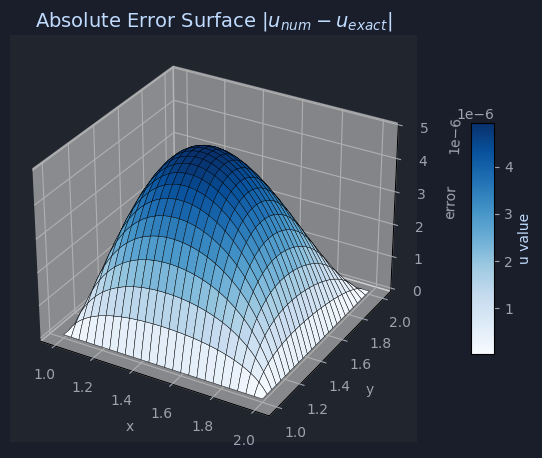

In [107]:
# Compute error surface
error = np.abs(u_numeric - u_true)

# Plot error surface using your custom theme
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
fig.patch.set_facecolor(colors["slategray"])
ax.set_facecolor(colors["midnight"])

# Plot error surface
surf = ax.plot_surface(X, Y, error, cmap='Blues', edgecolor='k', linewidth=0.3)

# Axis labels and title
ax.set_title("Absolute Error Surface $|u_{num} - u_{exact}|$", color=colors["lightblue"], fontsize=14)
ax.set_xlabel("x", color=colors["softgray"])
ax.set_ylabel("y", color=colors["softgray"])
ax.set_zlabel("error", color=colors["softgray"])
ax.tick_params(colors=colors["softgray"])

# Colorbar

# Color bar
cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)
cb.set_label("u value", color=colors["lightblue"])
cb.ax.tick_params(colors=colors["softgray"])
plt.show()



## 4.

Repeat Exercise 3(a) using extrapolation with $h_0 = 0.2$, $h_1 = h_0 / 2$, and $h_2 = h_0 / 4$.

In [108]:
# Define domains and exact solution
a, b = 0, 1
c, d = 0, 1
u_exact = lambda x, y: x * y

# Function to solve and return error at a given resolution
def solve_and_error(h):
    Nx = int((b - a) / h)
    Ny = int((d - c) / h)
    
    f_func = lambda x, y: np.zeros_like(x)
    g_bottom = lambda x: 0 * x
    g_top = lambda x: x
    g_left = lambda y: 0 * y
    g_right = lambda y: y

    solver = PoissonSolver2D(a, b, c, d, Nx, Ny, f_func,
                             g_left=g_left, g_right=g_right,
                             g_bottom=g_bottom, g_top=g_top)
    u_numeric = solver.solve()
    X, Y = solver.X, solver.Y
    u_true = u_exact(X, Y)
    error = np.abs(u_numeric - u_true)
    max_error = np.max(error)
    return u_numeric, u_true, max_error

# Solve at three resolutions
h0 = 0.2
h1 = h0 / 2
h2 = h0 / 4

u0, u_true0, err0 = solve_and_error(h0)
u1, u_true1, err1 = solve_and_error(h1)
u2, u_true2, err2 = solve_and_error(h2)

(err0, err1, err2)


(np.float64(1.1102230246251565e-16),
 np.float64(1.1102230246251565e-16),
 np.float64(5.551115123125783e-16))

## Applied Exercises

### 5.

A coaxial cable is made of a 0.1-in.-square inner conductor and a 0.5-in.-square outer conductor.  
The potential at a point in the cross section of the cable is described by Laplace’s equation.  
Suppose the inner conductor is kept at 0 volts and the outer conductor is kept at 110 volts.  
Find the potential between the two conductors by placing a grid with horizontal mesh spacing  
$h = 0.1$ in. and vertical mesh spacing $k = 0.1$ in. on the region

$$
D = \{(x, y) \mid 0 \leq x, y \leq 0.5 \}.
$$

Approximate the solution to Laplace’s equation at each grid point and use the two sets of boundary conditions to derive a linear system to be solved by the Gauss-Seidel method.

---



In [109]:
# Define the PoissonSolver2D-compatible boundary and domain setup for coaxial cable

# Redefine the f function for Laplace's equation
f_func = lambda x, y: np.zeros_like(x)

# Define domain
a, b = 0, 0.5
c, d = 0, 0.5
hx = hy = 0.01
Nx = int((b - a) / hx)
Ny = int((d - c) / hy)

# Redefine PoissonSolver2D to accept masks (fixed voltages)
class PoissonSolver2D_Coax:
    def __init__(self, a, b, c, d, Nx, Ny, f_func, fixed_mask, fixed_values):
        self.a, self.b, self.c, self.d = a, b, c, d
        self.Nx, self.Ny = Nx, Ny
        self.hx = (b - a) / Nx
        self.hy = (d - c) / Ny
        self.x = np.linspace(a, b, Nx + 1)
        self.y = np.linspace(c, d, Ny + 1)
        self.X, self.Y = np.meshgrid(self.x, self.y, indexing='ij')

        self.f_func = f_func
        self.f = f_func(self.X, self.Y)

        self.fixed_mask = fixed_mask
        self.u = fixed_values.copy()

    def solve(self, tol=1e-4, max_iter=10000):
        u = self.u
        for it in range(max_iter):
            u_old = u.copy()
            for i in range(1, self.Nx):
                for j in range(1, self.Ny):
                    if not self.fixed_mask[i, j]:
                        u[i, j] = 0.25 * (u[i+1, j] + u[i-1, j] +
                                          u[i, j+1] + u[i, j-1])
            err = np.max(np.abs(u - u_old))
            if err < tol:
                break
        self.u = u
        return u, it, err

# Construct the fixed mask and values
fixed_mask = np.zeros((Nx + 1, Ny + 1), dtype=bool)
u_fixed = np.zeros((Nx + 1, Ny + 1))

# Outer conductor (110V) on edges
u_fixed[0, :] = u_fixed[-1, :] = u_fixed[:, 0] = u_fixed[:, -1] = 110
fixed_mask[0, :] = fixed_mask[-1, :] = fixed_mask[:, 0] = fixed_mask[:, -1] = True

# Inner conductor (0V) in the center 0.1in x 0.1in region
for i in range(Nx + 1):
    for j in range(Ny + 1):
        x, y = i * hx, j * hy
        if 0.2 <= x <= 0.3 and 0.2 <= y <= 0.3:
            u_fixed[i, j] = 0
            fixed_mask[i, j] = True

# Solve using the modified PoissonSolver2D class
coax_solver = PoissonSolver2D_Coax(a, b, c, d, Nx, Ny, f_func, fixed_mask, u_fixed)
u_coaxial, iters, err = coax_solver.solve()

# Save solution for plotting
Xc, Yc = coax_solver.X, coax_solver.Y
Uc = u_coaxial
(iters, err)


(905, np.float64(9.943171411919138e-05))

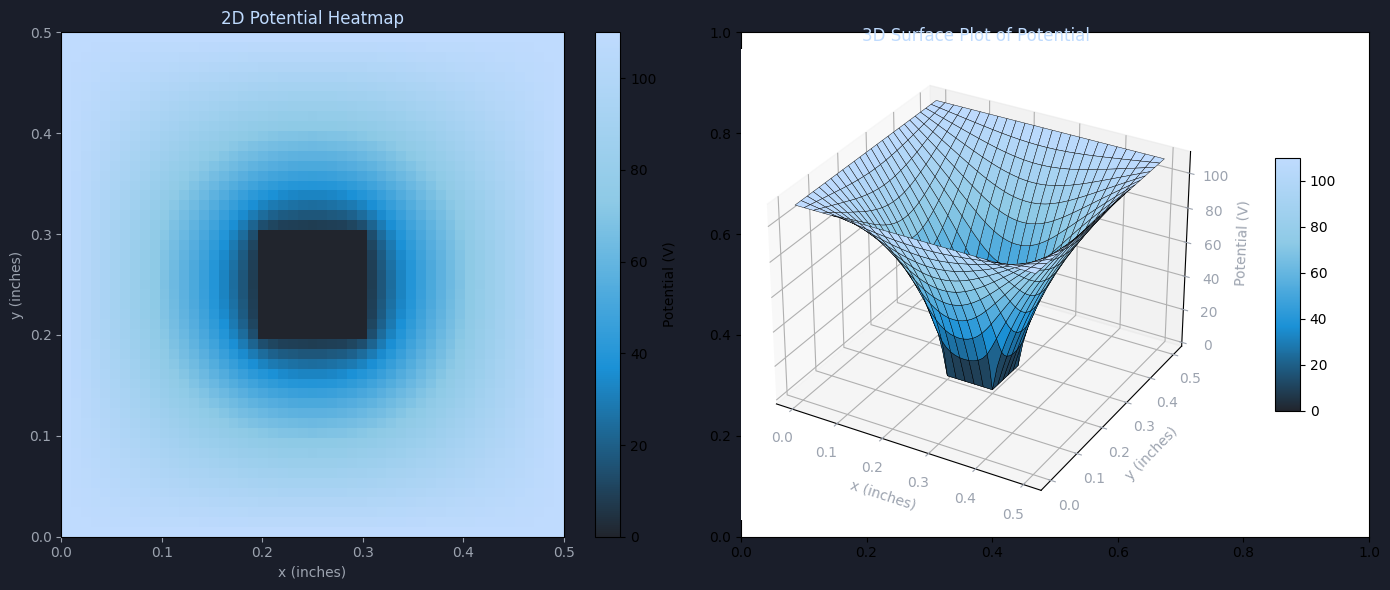

In [110]:
# Plot 2D heatmap and 3D surface for the coaxial cable solution
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
fig.patch.set_facecolor(colors["slategray"])

# 2D Heatmap
c1 = axs[0].imshow(Uc.T, origin='lower', extent=[0, 0.5, 0, 0.5],
                   cmap=custom_cmap, aspect='auto')
axs[0].set_title("2D Potential Heatmap", color=colors["lightblue"])
axs[0].set_xlabel("x (inches)", color=colors["softgray"])
axs[0].set_ylabel("y (inches)", color=colors["softgray"])
axs[0].tick_params(colors=colors["softgray"])
fig.colorbar(c1, ax=axs[0], label="Potential (V)")

# 3D Surface Plot
from mpl_toolkits.mplot3d import Axes3D
ax3d = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax3d.plot_surface(Xc, Yc, Uc, cmap=custom_cmap, edgecolor='k', linewidth=0.3)
ax3d.set_title("3D Surface Plot of Potential", color=colors["lightblue"])
ax3d.set_xlabel("x (inches)", color=colors["softgray"])
ax3d.set_ylabel("y (inches)", color=colors["softgray"])
ax3d.set_zlabel("Potential (V)", color=colors["softgray"])
ax3d.tick_params(colors=colors["softgray"])
fig.colorbar(surf, ax=ax3d, shrink=0.5, aspect=10, pad=0.1)

plt.tight_layout()
plt.show()


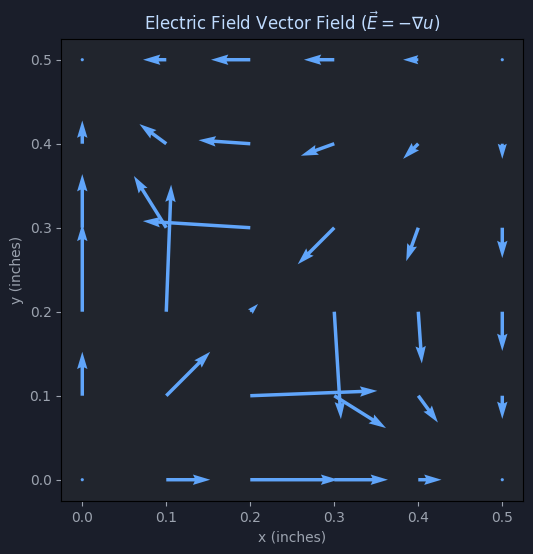

In [111]:
# Define the PoissonSolver2D-compatible boundary and domain setup for coaxial cable

# Redefine the f function for Laplace's equation
f_func = lambda x, y: np.zeros_like(x)

# Define domain
a, b = 0, 0.5
c, d = 0, 0.5
hx = hy = 0.1
Nx = int((b - a) / hx)
Ny = int((d - c) / hy)

# Redefine PoissonSolver2D to accept masks (fixed voltages)
class PoissonSolver2D_Coax:
    def __init__(self, a, b, c, d, Nx, Ny, f_func, fixed_mask, fixed_values):
        self.a, self.b, self.c, self.d = a, b, c, d
        self.Nx, self.Ny = Nx, Ny
        self.hx = (b - a) / Nx
        self.hy = (d - c) / Ny
        self.x = np.linspace(a, b, Nx + 1)
        self.y = np.linspace(c, d, Ny + 1)
        self.X, self.Y = np.meshgrid(self.x, self.y, indexing='ij')

        self.f_func = f_func
        self.f = f_func(self.X, self.Y)

        self.fixed_mask = fixed_mask
        self.u = fixed_values.copy()

    def solve(self, tol=1e-4, max_iter=10000):
        u = self.u
        for it in range(max_iter):
            u_old = u.copy()
            for i in range(1, self.Nx):
                for j in range(1, self.Ny):
                    if not self.fixed_mask[i, j]:
                        u[i, j] = 0.25 * (u[i+1, j] + u[i-1, j] +
                                          u[i, j+1] + u[i, j-1])
            err = np.max(np.abs(u - u_old))
            if err < tol:
                break
        self.u = u
        return u, it, err

# Construct the fixed mask and values
fixed_mask = np.zeros((Nx + 1, Ny + 1), dtype=bool)
u_fixed = np.zeros((Nx + 1, Ny + 1))

# Outer conductor (110V) on edges
u_fixed[0, :] = u_fixed[-1, :] = u_fixed[:, 0] = u_fixed[:, -1] = 110
fixed_mask[0, :] = fixed_mask[-1, :] = fixed_mask[:, 0] = fixed_mask[:, -1] = True

# Inner conductor (0V) in the center 0.1in x 0.1in region
for i in range(Nx + 1):
    for j in range(Ny + 1):
        x, y = i * hx, j * hy
        if 0.2 <= x <= 0.3 and 0.2 <= y <= 0.3:
            u_fixed[i, j] = 0
            fixed_mask[i, j] = True

# Solve using the modified PoissonSolver2D class
coax_solver = PoissonSolver2D_Coax(a, b, c, d, Nx, Ny, f_func, fixed_mask, u_fixed)
u_coaxial, iters, err = coax_solver.solve()

# Save solution for plotting
Xc, Yc = coax_solver.X, coax_solver.Y
Uc = u_coaxial
(iters, err)

# Compute electric field components: E = -grad(u)
Ey, Ex = np.gradient(-Uc, hy, hx)  # Note: gradient returns ∂/∂y first, so reverse order

# Plot vector field of electric field lines
fig, ax = plt.subplots(figsize=(6, 6))
fig.patch.set_facecolor(colors["slategray"])
ax.set_facecolor(colors["midnight"])

# Quiver plot of E-field
q = ax.quiver(Xc, Yc, Ex, Ey, scale=2000, color=colors["hoverblue"])
ax.set_title("Electric Field Vector Field ($\\vec{E} = -\\nabla u$)", color=colors["lightblue"])
ax.set_xlabel("x (inches)", color=colors["softgray"])
ax.set_ylabel("y (inches)", color=colors["softgray"])
ax.tick_params(colors=colors["softgray"])
ax.set_aspect('equal')

plt.show()


# gemini attempt

Gauss-Seidel converged in 36 iterations with max difference = 9.12e-06


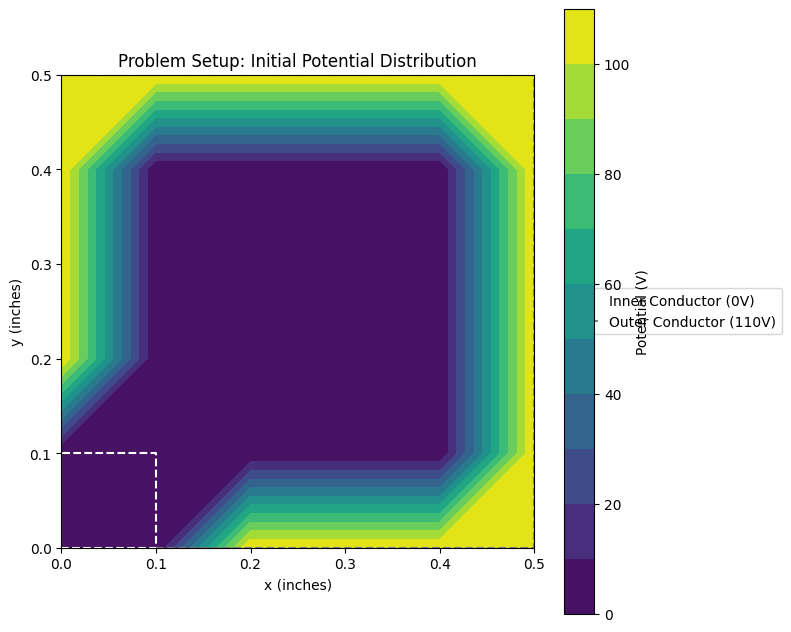

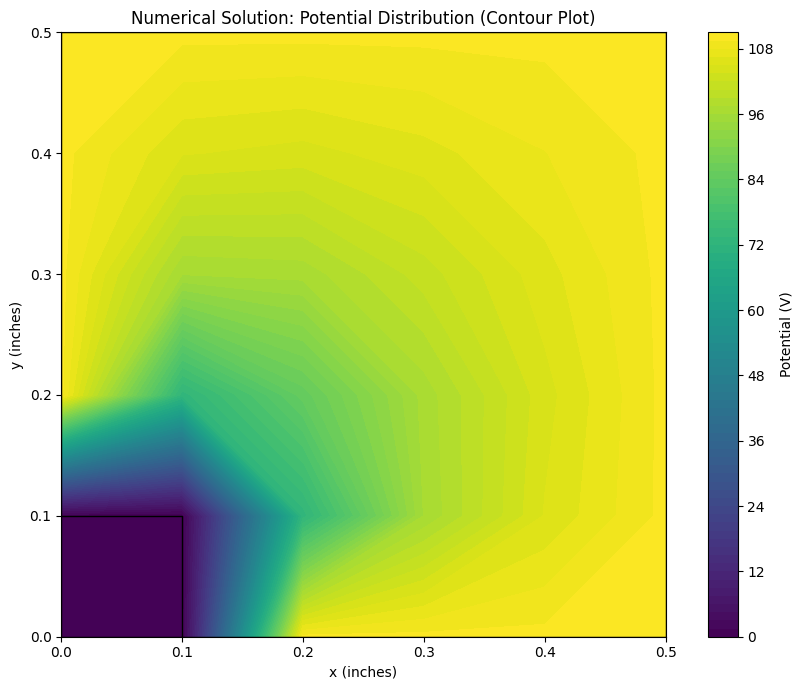

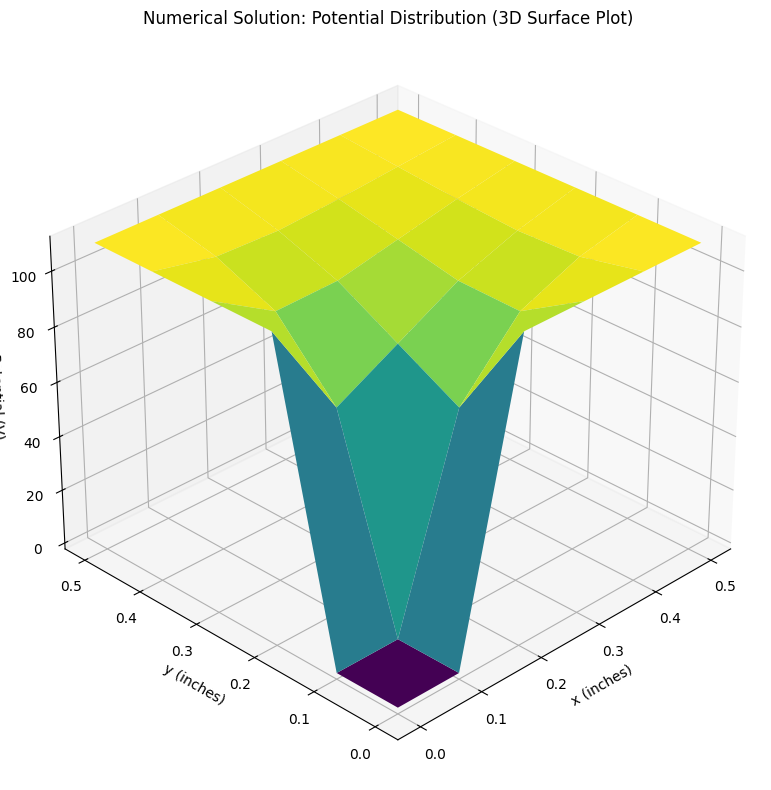


Selected potential values from the solution:
U(0.2, 0.1) (u_21) = 72.69 V
U(0.1, 0.2) (u_12) = 72.69 V
U(0.2, 0.2) (u_22) = 84.65 V
U(0.3, 0.3) (u_33) = 101.25 V
U(0.4, 0.4) (u_44) = 107.95 V


In [112]:
# Grid parameters
N_points = 6  # Number of grid points in each direction (indices 0 to 5)
h_spacing = 0.1 # Mesh spacing in inches
x_coords = np.linspace(0, (N_points-1)*h_spacing, N_points) # x coordinates: 0, 0.1, ..., 0.5
y_coords = np.linspace(0, (N_points-1)*h_spacing, N_points) # y coordinates: 0, 0.1, ..., 0.5

# Initialize potential array U
# U[i, j] will correspond to potential at (x_coords[i], y_coords[j])
# Initial guess for interior points (e.g., average of 0 and 110, or just 0)
U = np.full((N_points, N_points), 0.0) 

# Apply Boundary Conditions
# Inner conductor at 0V (points (0,0), (0.1,0), (0,0.1), (0.1,0.1))
U[0,0] = 0.0
U[1,0] = 0.0
U[0,1] = 0.0
U[1,1] = 0.0

# Outer conductor at 110V
# Top edge: y=0.5 (j_idx=5)
U[:, 5] = 110.0  # U[0,5] to U[5,5]
# Right edge: x=0.5 (i_idx=5)
U[5, :] = 110.0  # U[5,0] to U[5,5] (U[5,5] is already set by previous line)

# Bottom edge y=0 (j_idx=0), for x > 0.1 (i.e., i_idx = 2, 3, 4)
U[2,0] = 110.0
U[3,0] = 110.0
U[4,0] = 110.0
# U[5,0] is already 110V from U[5,:]

# Left edge x=0 (i_idx=0), for y > 0.1 (i.e., j_idx = 2, 3, 4)
U[0,2] = 110.0
U[0,3] = 110.0
U[0,4] = 110.0
# U[0,5] is already 110V from U[:,5]

# Store initial U for plotting the setup
U_initial = U.copy()

# Gauss-Seidel Iteration
max_iterations = 5000  # Maximum number of iterations
tolerance = 1e-5      # Convergence tolerance
iteration_count = 0

for iter_num in range(max_iterations):
    max_diff_in_iteration = 0.0  # Reset max difference for this iteration

    # Loop over interior grid points (where potential is unknown)
    # x-indices: i_idx from 0 to N_points-1
    # y-indices: j_idx from 0 to N_points-1
    for j_idx in range(N_points):  # y-coordinate index
        for i_idx in range(N_points):  # x-coordinate index

            # Check if current point (i_idx, j_idx) is a fixed boundary or inner conductor point.
            # If so, skip (its value should not change).

            # Inner conductor points (0V)
            if (i_idx == 0 and j_idx == 0) or \
               (i_idx == 1 and j_idx == 0) or \
               (i_idx == 0 and j_idx == 1) or \
               (i_idx == 1 and j_idx == 1):
                continue

            # Outer conductor points (110V)
            if j_idx == 5 or i_idx == 5: # Top or right edge
                continue
            if j_idx == 0 and i_idx >= 2: # Bottom edge (part of outer conductor)
                continue
            if i_idx == 0 and j_idx >= 2: # Left edge (part of outer conductor)
                continue
            
            # If we reach here, (i_idx, j_idx) is one of the 15 unknown points.
            # These points must be within the ranges:
            # j_idx=1: i_idx=2,3,4
            # j_idx=2: i_idx=1,2,3,4
            # j_idx=3: i_idx=1,2,3,4
            # j_idx=4: i_idx=1,2,3,4

            old_val_at_point = U[i_idx, j_idx]
            
            # Apply the five-point stencil for Laplace's equation
            new_val = 0.25 * (U[i_idx+1, j_idx] +  # Right neighbor
                              U[i_idx-1, j_idx] +  # Left neighbor
                              U[i_idx, j_idx+1] +  # Top neighbor
                              U[i_idx, j_idx-1])   # Bottom neighbor
            
            U[i_idx, j_idx] = new_val
            
            current_diff = abs(new_val - old_val_at_point)
            if current_diff > max_diff_in_iteration:
                max_diff_in_iteration = current_diff
                
    iteration_count = iter_num + 1
    if max_diff_in_iteration < tolerance:
        print(f"Gauss-Seidel converged in {iteration_count} iterations with max difference = {max_diff_in_iteration:.2e}")
        break
else: # Executed if the loop completes without breaking
    print(f"Gauss-Seidel did not converge after {max_iterations} iterations. Max difference = {max_diff_in_iteration:.2e}")

# --- Plotting ---

# Create meshgrid for plotting
# `indexing='xy'` (default for meshgrid) means X_plot[j,i] = x_coords[i] and Y_plot[j,i] = y_coords[j]
# Our U array is U[i,j] for (x_coords[i], y_coords[j]), so we need U.T for plotting.
X_plot, Y_plot = np.meshgrid(x_coords, y_coords, indexing='xy')

# Plot 1: Problem Setup (Initial state of U)
plt.figure(figsize=(9, 7)) # Adjusted figure size for legend
plt.contourf(X_plot, Y_plot, U_initial.T, levels=np.linspace(0, 110, 12), cmap='viridis')
plt.colorbar(label='Potential (V)')
# Conductor boundaries
plt.plot([0, 0.1, 0.1, 0, 0], [0, 0, 0.1, 0.1, 0], color='white', linestyle='--', linewidth=1.5, label='Inner Conductor (0V)')
plt.plot([0.1, 0.5, 0.5, 0, 0.1], [0, 0, 0.5, 0.5, 0.5], color='gray', linestyle='--', linewidth=1.5) # Outer boundary part 1
plt.plot([0,0], [0.1, 0.5], color='gray', linestyle='--', linewidth=1.5, label='Outer Conductor (110V)') # Outer boundary part 2
plt.title('Problem Setup: Initial Potential Distribution')
plt.xlabel('x (inches)')
plt.ylabel('y (inches)')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
plt.show()


# Plot 2: Numerical Solution (Contour Plot)
plt.figure(figsize=(9, 7))
contour = plt.contourf(X_plot, Y_plot, U.T, levels=100, cmap='viridis') # Smoother contours
plt.colorbar(contour, label='Potential (V)')
# Plot conductor boundaries on top for clarity
plt.plot([0, 0.1, 0.1, 0, 0], [0, 0, 0.1, 0.1, 0], color='black', linewidth=1)
plt.plot([0.1, 0.5], [0,0], color='black', linewidth=1) # Bottom edge, outer part
plt.plot([0,0], [0.1, 0.5], color='black', linewidth=1) # Left edge, outer part
plt.plot([0, 0.5], [0.5,0.5], color='black', linewidth=1) # Top edge
plt.plot([0.5, 0.5], [0,0.5], color='black', linewidth=1) # Right edge
plt.title('Numerical Solution: Potential Distribution (Contour Plot)')
plt.xlabel('x (inches)')
plt.ylabel('y (inches)')
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

# Plot 3: Numerical Solution (3D Surface Plot)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_plot, Y_plot, U.T, cmap='viridis', edgecolor='none')
ax.set_title('Numerical Solution: Potential Distribution (3D Surface Plot)')
ax.set_xlabel('x (inches)')
ax.set_ylabel('y (inches)')
ax.set_zlabel('Potential (V)')
ax.view_init(elev=30, azim=-135) # Adjust view angle for better visualization
plt.tight_layout()
plt.show()

# Optional: Print some potential values at specific points
print("\nSelected potential values from the solution:")
print(f"U(0.2, 0.1) (u_21) = {U[2,1]:.2f} V")
print(f"U(0.1, 0.2) (u_12) = {U[1,2]:.2f} V")
print(f"U(0.2, 0.2) (u_22) = {U[2,2]:.2f} V")
print(f"U(0.3, 0.3) (u_33) = {U[3,3]:.2f} V")
print(f"U(0.4, 0.4) (u_44) = {U[4,4]:.2f} V")

## deepseek attempt


Converged after 13 iterations


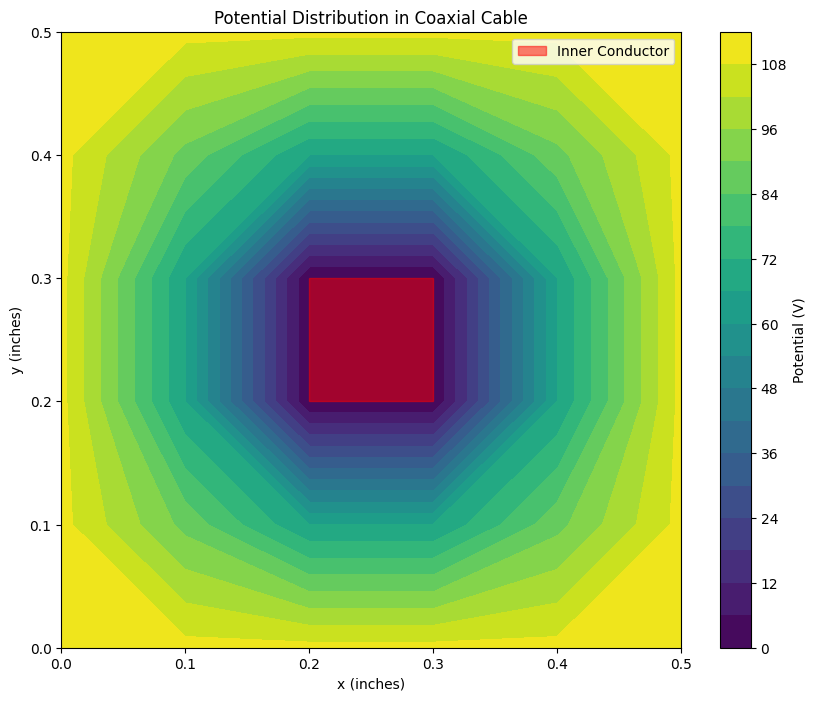

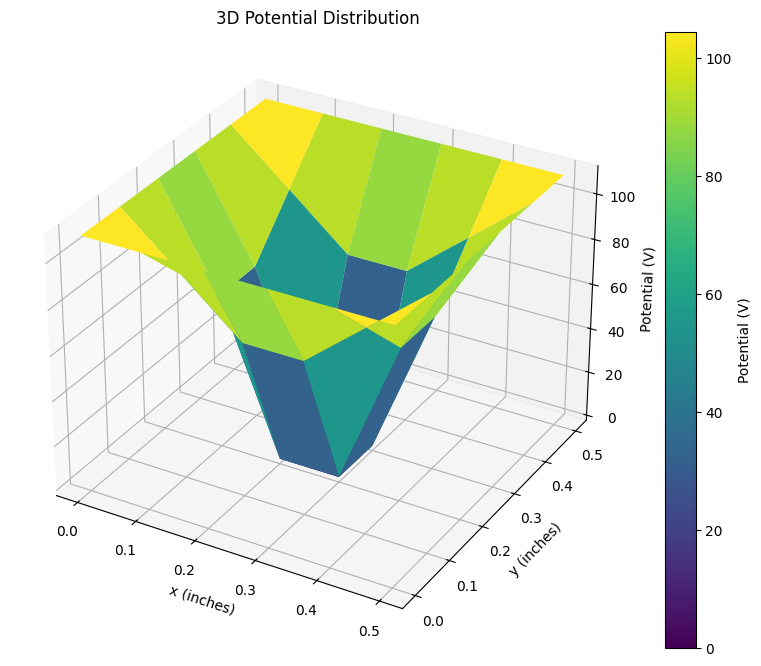

In [113]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize parameters
h = 0.1  # inch (grid spacing)
size = 6  # 0.0 to 0.5 in steps of 0.1 (6 points)
inner_start, inner_end = 2, 4  # 0.2-0.3 inch indices (0.1" square)
outer_voltage = 110
inner_voltage = 0

# Initialize voltage grid
V = np.zeros((size, size))

# Set boundary conditions (outer conductor)
V[0, :] = outer_voltage
V[-1, :] = outer_voltage
V[:, 0] = outer_voltage
V[:, -1] = outer_voltage

# Set inner conductor voltage
V[inner_start:inner_end, inner_start:inner_end] = inner_voltage

# Create mask for update points (True = needs calculation)
update_mask = np.full((size, size), False)
update_mask[1:-1, 1:-1] = True  # Exclude outer boundaries
update_mask[inner_start:inner_end, inner_start:inner_end] = False  # Exclude inner conductor

# Gauss-Seidel parameters
max_iter = 10000
tolerance = 1e-4
converged = False

# Gauss-Seidel iteration
for iteration in range(max_iter):
    max_error = 0.0
    for i in range(size):
        for j in range(size):
            if update_mask[i, j]:
                old_val = V[i, j]
                # Update using latest neighboring values
                V[i, j] = 0.25 * (V[i-1, j] + V[i+1, j] + V[i, j-1] + V[i, j+1])
                max_error = max(max_error, abs(old_val - V[i, j]))
    
    if max_error < tolerance:
        print(f"Converged after {iteration+1} iterations")
        converged = True
        break

if not converged:
    print(f"Did not converge after {max_iter} iterations")

# Create grid coordinates
x = np.linspace(0, 0.5, size)
y = np.linspace(0, 0.5, size)
X, Y = np.meshgrid(x, y)

# Create plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(X, Y, V, levels=20, cmap='viridis')
plt.colorbar(contour, label='Potential (V)')

# Add inner conductor rectangle
plt.gca().add_patch(plt.Rectangle(
    (0.2, 0.2), 0.1, 0.1, 
    fill=True, color='red', alpha=0.5, label='Inner Conductor'
))

# Add labels and title
plt.xlabel('x (inches)')
plt.ylabel('y (inches)')
plt.title('Potential Distribution in Coaxial Cable')
plt.legend()

# Show 3D surface plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, V, cmap='viridis', rstride=1, cstride=1)
fig.colorbar(surf, ax=ax, label='Potential (V)')
ax.set_xlabel('x (inches)')
ax.set_ylabel('y (inches)')
ax.set_zlabel('Potential (V)')
ax.set_title('3D Potential Distribution')

plt.show()

### 6.

A 6-cm by 5-cm rectangular silver plate has heat being uniformly generated at each point at the rate  
$q = 1.5$ cal/cm³·sec. Let $x$ represent the distance along the edge of the plate of length 6 cm and $y$ be the distance along the edge of the plate of length 5 cm.  
Suppose the temperature $u$ along the edges is kept at the following temperatures:

- $u(x, 0) = x(6 - x)$, $u(x, 5) = 0$, $0 \leq x \leq 6$
- $u(0, y) = y(5 - y)$, $u(6, y) = 0$, $0 \leq y \leq 5$

The Poisson equation governing the steady-state temperature $u = u(x, y)$ is:

$$
\frac{\partial^2 u}{\partial x^2}(x, y) + \frac{\partial^2 u}{\partial y^2}(x, y) = -\frac{q}{K}, \quad 0 < x < 6,\quad 0 < y < 5,
$$

where $K$, the thermal conductivity, is $1.04$ cal/cm·deg·sec.  
Approximate the temperature $u(x, y)$ using Algorithm 12.1 with $h = 0.4$ and $k = \frac{1}{3}$.


In [114]:
# Redefine PoissonSolver2D
class PoissonSolver2D:
    def __init__(self, a, b, c, d, Nx, Ny, f_func,
                 g_left, g_right, g_bottom, g_top):
        self.a, self.b, self.c, self.d = a, b, c, d
        self.Nx, self.Ny = Nx, Ny
        self.hx = (b - a) / Nx
        self.hy = (d - c) / Ny
        self.x = np.linspace(a, b, Nx + 1)
        self.y = np.linspace(c, d, Ny + 1)
        self.X, self.Y = np.meshgrid(self.x, self.y, indexing='ij')

        self.f_func = f_func
        self.f = f_func(self.X, self.Y)

        self.g_left = g_left
        self.g_right = g_right
        self.g_bottom = g_bottom
        self.g_top = g_top

        self.u = np.zeros_like(self.f)
        self.apply_dirichlet_bc()

    def apply_dirichlet_bc(self):
        self.u[0, :] = self.g_left(self.y)
        self.u[-1, :] = self.g_right(self.y)
        self.u[:, 0] = self.g_bottom(self.x)
        self.u[:, -1] = self.g_top(self.x)

    def solve(self):
        Nx, Ny = self.Nx, self.Ny
        hx2 = self.hx ** 2
        hy2 = self.hy ** 2
        N = (Nx - 1) * (Ny - 1)

        A = lil_matrix((N, N))
        F = np.zeros(N)

        def idx(i, j):
            return (i - 1) * (Ny - 1) + (j - 1)

        for i in range(1, Nx):
            for j in range(1, Ny):
                k = idx(i, j)
                A[k, k] = -2.0 * (1 / hx2 + 1 / hy2)

                if i > 1:
                    A[k, idx(i - 1, j)] = 1 / hx2
                else:
                    F[k] -= self.u[i - 1, j] / hx2

                if i < Nx - 1:
                    A[k, idx(i + 1, j)] = 1 / hx2
                else:
                    F[k] -= self.u[i + 1, j] / hx2

                if j > 1:
                    A[k, idx(i, j - 1)] = 1 / hy2
                else:
                    F[k] -= self.u[i, j - 1] / hy2

                if j < Ny - 1:
                    A[k, idx(i, j + 1)] = 1 / hy2
                else:
                    F[k] -= self.u[i, j + 1] / hy2

                F[k] += self.f[i, j]

        u_inner = spsolve(A.tocsr(), F)

        for i in range(1, Nx):
            for j in range(1, Ny):
                self.u[i, j] = u_inner[idx(i, j)]

        return self.u

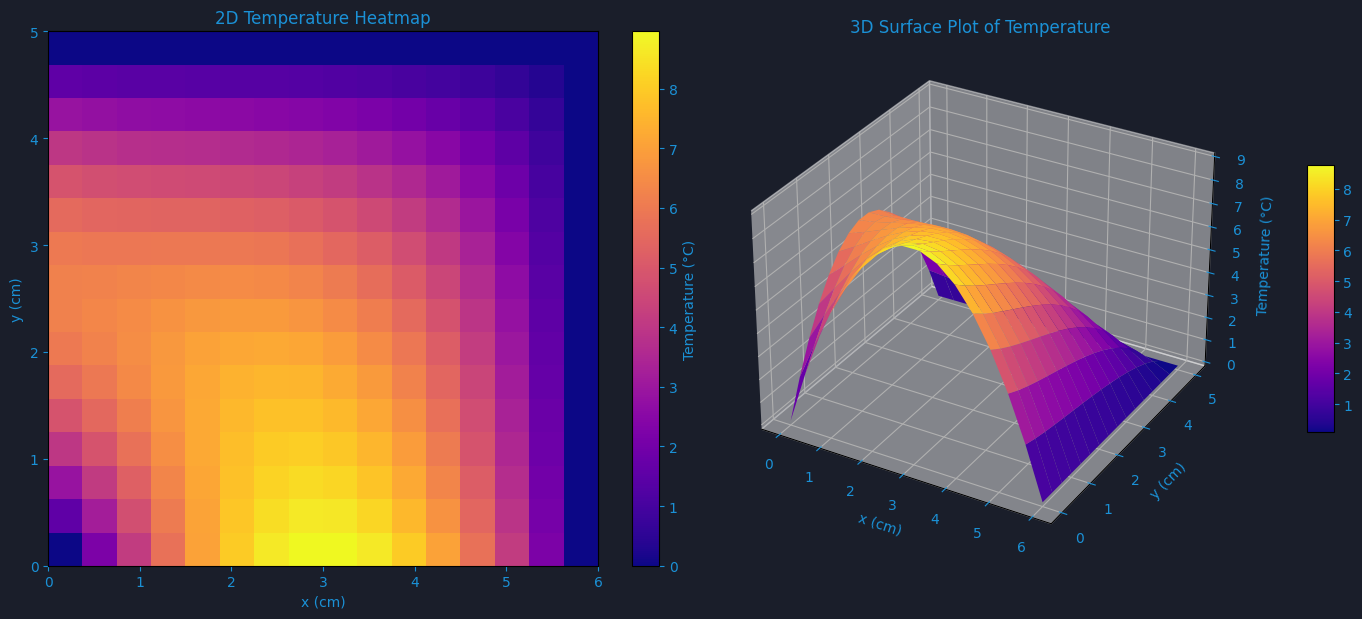

In [115]:
# Define physical and numerical constants
q = 1.5       # cal/cm³·sec
K = 1.04      # cal/cm·deg·sec
rhs_value = -q / K

# Domain and grid setup
a, b = 0, 6
c, d = 0, 5
hx = 0.4
hy = 1/3
Nx = int((b - a) / hx)
Ny = int((d - c) / hy)

# Define grid and functions
x = np.linspace(a, b, Nx + 1)
y = np.linspace(c, d, Ny + 1)
X, Y = np.meshgrid(x, y, indexing='ij')

# RHS of Poisson equation
f_func = lambda x, y: rhs_value * np.ones_like(x)

# Boundary conditions
g_bottom = lambda x: x * (6 - x)
g_top = lambda x: np.zeros_like(x)
g_left = lambda y: y * (5 - y)
g_right = lambda y: np.zeros_like(y)

# Solve using PoissonSolver2D
solver = PoissonSolver2D(a, b, c, d, Nx, Ny, f_func,
                         g_left=g_left, g_right=g_right,
                         g_bottom=g_bottom, g_top=g_top)
u_numeric = solver.solve()

# Save grid for plotting
Xh, Yh = solver.X, solver.Y
Uh = u_numeric

fig = plt.figure(figsize=(14, 6))
fig.patch.set_facecolor(colors["slategray"])

# 2D heatmap axis
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_facecolor(colors["slategray"])
c1 = ax1.imshow(Uh.T, origin='lower', extent=[0, 6, 0, 5],
                cmap='plasma', aspect='auto')
ax1.set_title("2D Temperature Heatmap", color=colors["mathblue"])
ax1.set_xlabel("x (cm)", color=colors["mathblue"])
ax1.set_ylabel("y (cm)", color=colors["mathblue"])
ax1.tick_params(colors=colors["mathblue"])
cbar1 = fig.colorbar(c1, ax=ax1, label="Temperature (°C)")
cbar1.ax.yaxis.label.set_color(colors["mathblue"])
cbar1.ax.tick_params(colors=colors["mathblue"])

# 3D surface plot axis
ax3d = fig.add_subplot(1, 2, 2, projection='3d')
ax3d.set_facecolor(colors["slategray"])
surf = ax3d.plot_surface(Xh, Yh, Uh, cmap='plasma', edgecolor='none', linewidth=0.1)
ax3d.set_title("3D Surface Plot of Temperature", color=colors["mathblue"])
ax3d.set_xlabel("x (cm)", color=colors["mathblue"])
ax3d.set_ylabel("y (cm)", color=colors["mathblue"])
ax3d.set_zlabel("Temperature (°C)", color=colors["mathblue"])
ax3d.tick_params(colors=colors["mathblue"])
cbar2 = fig.colorbar(surf, ax=ax3d, shrink=0.5, aspect=10, pad=0.1)
cbar2.ax.yaxis.label.set_color(colors["mathblue"])
cbar2.ax.tick_params(colors=colors["mathblue"])

plt.tight_layout(pad=0)
plt.show()


## Theoretical Exercises

### 7. 
Construct an algorithm similar to Algorithm 12.1, except use the SOR method with optimal $\omega$ instead of the Gauss-Seidel method for solving the linear system.

### 8. 
Repeat Exercise 3 using the algorithm constructed in Exercise 7.




In [116]:
def sor_solver(f, u, fixed_mask, hx, hy, max_iter=10000, tol=1e-5):
    Nx, Ny = u.shape[0] - 1, u.shape[1] - 1
    hx2 = hx ** 2
    hy2 = hy ** 2
    denom = 2 * (1 / hx2 + 1 / hy2)

    # Optimal relaxation parameter
    omega = 2 / (1 + np.sin(np.pi / max(Nx, Ny)))

    for it in range(max_iter):
        u_old = u.copy()
        for i in range(1, Nx):
            for j in range(1, Ny):
                if not fixed_mask[i, j]:
                    term_x = (u[i+1, j] + u[i-1, j]) / hx2
                    term_y = (u[i, j+1] + u[i, j-1]) / hy2
                    residual = (term_x + term_y - f[i, j]) / denom
                    u[i, j] = (1 - omega) * u[i, j] + omega * residual

        err = np.max(np.abs(u - u_old))
        if err < tol:
            break

    return u, it, err


In [117]:
# Define the domain and parameters
a, b = 0, 1
c, d = 0, 1
hx = hy = 0.2
Nx = int((b - a) / hx)
Ny = int((d - c) / hy)

x = np.linspace(a, b, Nx + 1)
y = np.linspace(c, d, Ny + 1)
X, Y = np.meshgrid(x, y, indexing='ij')

# RHS for Laplace's equation
f = np.zeros_like(X)

# Exact solution
u_exact = lambda x, y: x * y
u_true = u_exact(X, Y)

# Initialize u and fixed mask
u = np.zeros_like(X)
fixed_mask = np.zeros_like(X, dtype=bool)

# Apply boundary conditions
u[:, 0] = 0            # u(x, 0)
u[:, -1] = x           # u(x, 1)
u[0, :] = 0            # u(0, y)
u[-1, :] = y           # u(1, y)

fixed_mask[:, 0] = True
fixed_mask[:, -1] = True
fixed_mask[0, :] = True
fixed_mask[-1, :] = True

# Define SOR solver
def sor_solver(f, u, fixed_mask, hx, hy, max_iter=10000, tol=1e-5):
    Nx, Ny = u.shape[0] - 1, u.shape[1] - 1
    hx2 = hx ** 2
    hy2 = hy ** 2
    denom = 2 * (1 / hx2 + 1 / hy2)
    omega = 2 / (1 + np.sin(np.pi / max(Nx, Ny)))  # optimal omega

    for it in range(max_iter):
        u_old = u.copy()
        for i in range(1, Nx):
            for j in range(1, Ny):
                if not fixed_mask[i, j]:
                    term_x = (u[i+1, j] + u[i-1, j]) / hx2
                    term_y = (u[i, j+1] + u[i, j-1]) / hy2
                    residual = (term_x + term_y - f[i, j]) / denom
                    u[i, j] = (1 - omega) * u[i, j] + omega * residual

        err = np.max(np.abs(u - u_old))
        if err < tol:
            break

    return u, it, err

# Solve using SOR
u_sor, iterations, error = sor_solver(f, u, fixed_mask, hx, hy)
u_error = np.abs(u_sor - u_true)

(u_sor, u_true, u_error.max(), iterations)

(array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.03999832, 0.07999857, 0.11999938, 0.15999978,
         0.2       ],
        [0.        , 0.07999857, 0.15999889, 0.23999939, 0.31999979,
         0.4       ],
        [0.        , 0.11999938, 0.23999939, 0.35999969, 0.47999989,
         0.6       ],
        [0.        , 0.15999978, 0.31999979, 0.47999989, 0.63999997,
         0.8       ],
        [0.        , 0.2       , 0.4       , 0.6       , 0.8       ,
         1.        ]]),
 array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.04, 0.08, 0.12, 0.16, 0.2 ],
        [0.  , 0.08, 0.16, 0.24, 0.32, 0.4 ],
        [0.  , 0.12, 0.24, 0.36, 0.48, 0.6 ],
        [0.  , 0.16, 0.32, 0.48, 0.64, 0.8 ],
        [0.  , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ]]),
 np.float64(1.6771419907857243e-06),
 12)

## Discussion Questions

### 9. 
 The text describes the formation of equally spaced vertical grid lines and equally spaced horizontal grid lines. Can a variable grid size be used in the finite-difference method? If so, how could you implement this modification?
### 10.
 How would you space the grid lines in the case of an irregularly shaped domain?
### 11.
 Discuss multigrid methods for solving elliptical problems.